In [2]:
import pandas as pd
import numpy as np
from xbbg import blp
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.tsa.filters.hp_filter import hpfilter
import warnings
from typing import Dict, Any
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from hmmlearn.hmm import GaussianHMM
from hmmlearn import hmm
from scipy.spatial.distance import cosine
from scipy.stats import percentileofscore
from scipy.stats import norm
from typing import Tuple, Optional
from typing import Iterable
warnings.filterwarnings("ignore")

In [3]:
def data_load(source_dict: dict, start_date: str, end_date: str, freq: str = 'M') -> pd.DataFrame:
    
    # Fetch data
    df = blp.bdh(
        tickers=list(source_dict.keys()),
        flds='PX_LAST',
        start_date=start_date,
        end_date=end_date,
        Per=freq
    ).ffill().fillna(0)

    # Format DataFrame
    df = df.reset_index().rename(columns={'index': 'Date'})
    df.set_index('Date', inplace=True)
    df.index = pd.to_datetime(df.index)
    df.columns = list(source_dict.values())
    df = df.ffill().fillna(0)
    return df

def ema_wilder(series: pd.Series, nk: float) -> pd.Series:

    if nk <= 0:
        raise ValueError("nk must be positive")
    a = 1.0 / nk
    return series.ewm(alpha=a, adjust=False).mean()

def halflife_from_nk(nk: float) -> float:
    a = 1.0 / nk
    return np.log(0.5) / np.log(1.0 - a)

def cta_ewma_cross_signal(
    price: pd.Series,
    nk_short = (8, 16, 32),
    nk_long  = (24, 48, 96),
    vol_window_1 = 63,      # first normalization (3 months)
    vol_window_2 = 252,     # second normalization (1 year)
    weights = None
) -> pd.DataFrame:

    price = price.copy().astype(float).dropna()
    if len(price) < max(vol_window_1, vol_window_2) + 10:
        raise ValueError("Not enough data for the chosen rolling windows / warm-up.")

    if weights is None:
        weights = np.repeat(1.0 / len(nk_short), len(nk_short))
    else:
        weights = np.array(weights, dtype=float)
        weights = weights / weights.sum()

    df = pd.DataFrame(index=price.index)
    df['price'] = price

    # 1) compute EMAs for each k
    for i, (nks, nkl) in enumerate(zip(nk_short, nk_long), start=1):
        es = ema_wilder(price, nks)
        el = ema_wilder(price, nkl)
        df[f'EMA_s_{i}'] = es
        df[f'EMA_l_{i}'] = el
        # 2) x_k
        df[f'x_{i}'] = es - el

    # 3) first normalization: divide x_k by rolling std of price (vol_window_1)
    rolling_std_p = price.rolling(window=vol_window_1, min_periods=1).std()
    eps = 1e-12
    for i in range(1, len(nk_short) + 1):
        df[f'y_{i}'] = df[f'x_{i}'] / (rolling_std_p + eps)

    # 4) second normalization: divide y_k by rolling std of y_k (vol_window_2)
    for i in range(1, len(nk_short) + 1):
        rolling_std_y = df[f'y_{i}'].rolling(window=vol_window_2, min_periods=1).std()
        df[f'z_{i}'] = df[f'y_{i}'] / (rolling_std_y + eps)

    # 5) response function u_k( z ) = ( z * exp(-z^2 / 4) ) / (sqrt(2) * exp(-1/2))
    denom = np.sqrt(2.0) * np.exp(-0.5)   # paper's denominator: v2 * e^{-1/2}
    for i in range(1, len(nk_short) + 1):
        z = df[f'z_{i}'].fillna(0.0)   # fillna to allow mapping; later warm-up will be NaN'ed
        u = z * np.exp(- (z ** 2) / 4.0) / denom
        df[f'u_{i}'] = u.clip(-1.0, 1.0)

    # 6) weighted sum -> final signal
    u_cols = [f'u_{i}' for i in range(1, len(nk_short)+1)]
    df['signal'] = df[u_cols].multiply(weights).sum(axis=1)

    # compute arithmetic returns and strategy returns (lag signal by 1 day)
    df['returns'] = price.pct_change()   # arithmetic returns as in paper
    df['strategy_return'] = df['returns'] * df['signal'].shift(1)

    # warm-up: per paper we need at least:
    # - vol_window_1 - 1 days for first rolling std (they state 62 days needed)
    # - additional vol_window_2 - 1 days for second rolling std (they state 251 days)
    # - +1 day for arithmetic returns
    warmup_days = (vol_window_1 - 1) + (vol_window_2 - 1) + 1
    df.iloc[:warmup_days] = np.nan

    return df

def return_momentum(returns: pd.Series, lookback_months: int = 252, skip_months: int = 21) -> pd.Series:

    # Compute momentum signal
    returns = returns.pct_change().dropna()
    rolled = returns.shift(skip_months).rolling(lookback_months, min_periods=1)
    cum_ret = rolled.apply(lambda x: (1 + x).prod() - 1, raw=False)
    vol = returns.shift(skip_months).rolling(lookback_months, min_periods=1).std()
    momentum = (cum_ret / vol.replace(0, np.nan)).dropna()
    
    # Standardize to z-score
    #z = (momentum - momentum.mean()) / momentum.std(ddof=0)
    # Map to CDF (0-1)
    #cdf = norm.cdf(z)
    
    return momentum

In [4]:
assets = {
    "SPTR500N Index": "S&P 500",
    "RU20INTR Index": "Russell 2000",
    "TUKXG Index": "FTSE 100 TR GBP",
    "TMCXG Index": "FTSE 250 TR Index",
    "MSDE15XN Index": "Europe ex UK",
    "M7EUSC Index": "EUROPE Small cap",
    "TPXDDVD Index": "TOPIX TR Index",
    "NDUECAXJ INDEX": "Asia ex Japan",
    "SPGTINTR Index": "S&P Global Infras",
    "LG30TRUU Index": "Global High Yield",
    "LGCPTRGH Index": "Corporate bonds",
    "BCIW6B Index": "Short dated inflation linked",
    "H02662GB Index": "1-3 Year",
    "FTFIBGT Index": "Gilts",
    "LGAGTRGH Index": "Global Agg",
    "FTRFILA Index": "Index Linked Gilts",
    "GOLDLNPM Index": "LBMA Gold",
    "NEIXCTA Index": "CTA Index",
    "BXIIBGB0 INDEX": "Cash",
    "BERYTR Index": "Enhanced commodity Roll",
    "BNPIF73T Index": "Enhanced commodity carry",
    "NDDUWI Index": "World NR",
    "BCS5TRUU Index": "Converts",
    "M1EFEV Index": "EM Enhanced Value",
    "M7EUEV INDEX": "EUROPE enhanced value",
    "MAEUMMT INDEX": "EUROPE Momentum",
    "M1USMMT INDEX": "USA Momentum",
    "M1USQU INDEX": "MSCI USA Quality",
    "NDLVUK Index": "MSCI UK Value",
    "NDEUCHF Index": "China",
    "M1IN Index": "India",
    "NDUEEGF Index": "EM Index",
    "M1CXBRV Index": "EM ex China",
    "M1E2 Index": "Global ex US",
    "M1WD0IT Index": "Information Technology",
    "M1WD0EN Index": "Energy",
    "M1WD0FN Index": "Financials",
    "M1WD0HC Index": "Healthcare",
    "RUGL Index": "Global REITs",
    "NUPRA Index": "European REITs",
    "TEGASU Index": "Asian REITs",
    "TRNUSU Index": "US REITs",
    "NCUDWI Index": "World small cap",
    "M1WDHDVD Index": "Global Equity Income",
    "SRCATTRR Index": "Cat Bond",
    "LG20TRUU Index": "EMD HC",
    "I20344US Index": "EMD LC",
    "EMUSTRUU Index": "EMD Corporates",
    "IYG5X Index": "Subordinated Financial debt",
    "BCOMAGTR Index": "Agriculture",
    "BCOMINTR Index": "Industrial",
    "BCOMPRTR Index": "Precious",
    "JPOSCUVS Index": "Dispersion"
}

In [5]:
# Define date range
start_date_a = (datetime.now() - timedelta(days=365 * 20)).strftime('%Y-%m-%d')
end_date_a = datetime.now().strftime('%Y-%m-%d')

# Load asset returns data
asset_returns = data_load(assets, start_date_a, end_date_a, freq='D')

In [6]:
returns_df = {
    "S&P 500" : asset_returns['S&P 500'],
    "Russell 2000" : asset_returns['Russell 2000'],
    "FTSE 100 TR GBP" : asset_returns['FTSE 100 TR GBP'],
    "FTSE 250 TR Index" : asset_returns['FTSE 250 TR Index'],
    "Europe ex UK" : asset_returns['Europe ex UK'],
    "EUROPE Small cap" : asset_returns['EUROPE Small cap'],
    "TOPIX TR Index" : asset_returns['TOPIX TR Index'],
    "Asia ex Japan" : asset_returns['Asia ex Japan'],
    "S&P Global Infras" : asset_returns['S&P Global Infras'],
    "Global High Yield" : asset_returns['Global High Yield'],
    "Corporate bonds" : asset_returns['Corporate bonds'],
    "Short dated inflation linked" : asset_returns['Short dated inflation linked'],
    "1-3 Year" : asset_returns['1-3 Year'],
    "Gilts" : asset_returns['Gilts'],
    "Global Agg" : asset_returns['Global Agg'],
    "Index Linked Gilts" : asset_returns['Index Linked Gilts'],
    "LBMA Gold" : asset_returns['LBMA Gold'],
    "CTA Index" : asset_returns['CTA Index'],
    "Cash" : asset_returns['Cash'],
    "Enhanced commodity Roll" : asset_returns['Enhanced commodity Roll'],
    "Enhanced commodity carry" : asset_returns['Enhanced commodity carry'],
    "World NR" : asset_returns['World NR'],
    "Converts" : asset_returns['Converts'],
    "EM Enhanced Value" : asset_returns['EM Enhanced Value'],
    "EUROPE enhanced value" : asset_returns['EUROPE enhanced value'],
    "EUROPE Momentum" : asset_returns['EUROPE Momentum'],
    "USA Momentum" : asset_returns['USA Momentum'],
    "MSCI USA Quality" : asset_returns['MSCI USA Quality'],
    "MSCI UK Value" : asset_returns['MSCI UK Value'],
    "China" : asset_returns['China'],
    "India" : asset_returns['India'],
    "EM Index" : asset_returns['EM Index'],
    "EM ex China" : asset_returns['EM ex China'],
    "Global ex US" : asset_returns['Global ex US'],
    "Information Technology" : asset_returns['Information Technology'],
    "Energy" : asset_returns['Energy'],
    "Financials" : asset_returns['Financials'],
    "Healthcare" : asset_returns['Healthcare'],
    "Global REITs" : asset_returns['Global REITs'],
    "European REITs" : asset_returns['European REITs'],
    "Asian REITs" : asset_returns['Asian REITs'],
    "US REITs" : asset_returns['US REITs'],
    "World small cap" : asset_returns['World small cap'],
    "Global Equity Income" : asset_returns['Global Equity Income'],
    "Cat Bond" : asset_returns['Cat Bond'],
    "EMD HC" : asset_returns['EMD HC'],
    "EMD LC" : asset_returns['EMD LC'],
    "EMD Corporates" : asset_returns['EMD Corporates'],
    "Subordinated Financial debt" : asset_returns['Subordinated Financial debt'],
    "Agriculture" : asset_returns['Agriculture'],
    "Industrial" : asset_returns['Industrial'],
    "Precious" : asset_returns['Precious'],
    "Dispersion" : asset_returns['Dispersion']
}

In [7]:
cta_results = {}
for assets, df in returns_df.items():
    try:
        cta_results[assets] = cta_ewma_cross_signal(df)
    except Exception as e:
        print(f"{assets}: {e}")

mom_results = {}
for assets, df in returns_df.items():
    try:
        mom_results[assets] = return_momentum(df)
    except Exception as e:
        print(f"{assets}: {e}")

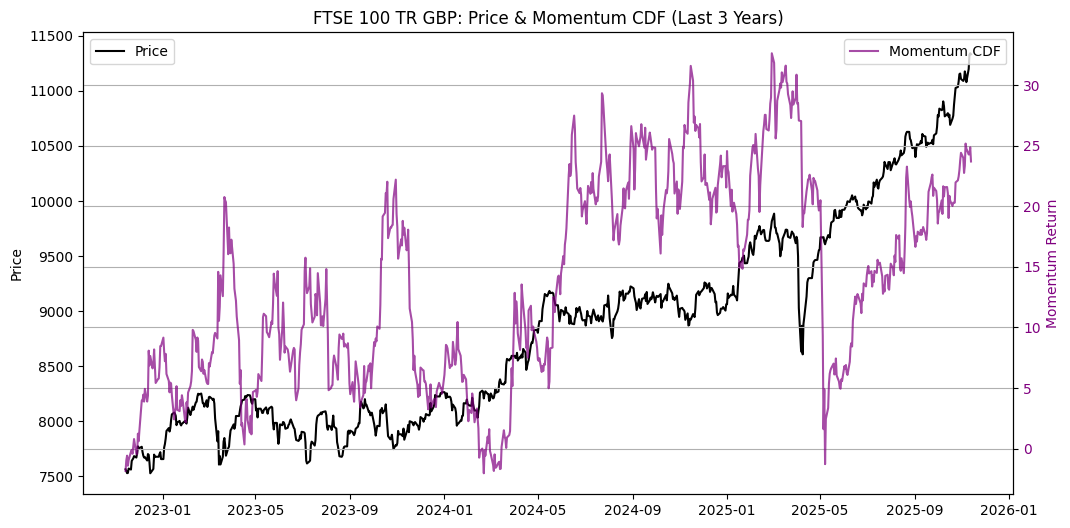

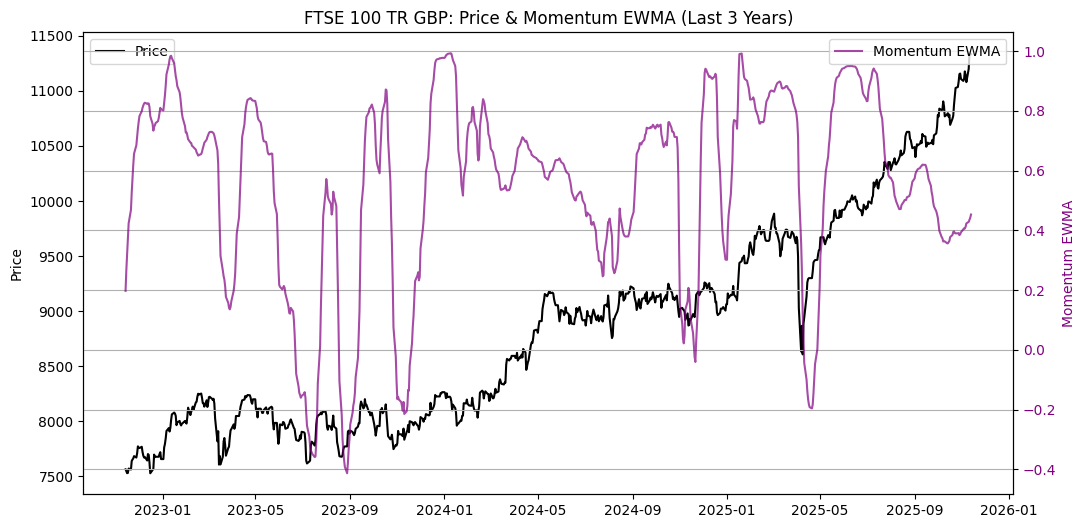

In [8]:
df = cta_results['FTSE 100 TR GBP'].dropna()
cdf = mom_results['FTSE 100 TR GBP'].dropna()

# Align indices for last 3 years
last_3_years = df.index >= (df.index.max() - pd.DateOffset(years=3))
df_recent = df.loc[last_3_years]
cdf_recent = cdf.loc[df_recent.index]  # align to df_recent's index

fig, ax1 = plt.subplots(figsize=(12,6))

# Plot price on ax1
ax1.plot(df_recent.index, df_recent['price'], label='Price', color='black')
ax1.set_ylabel('Price', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# Plot momentum CDF on ax2
ax2 = ax1.twinx()
ax2.plot(cdf_recent.index, cdf_recent, label='Momentum CDF', color='purple', alpha=0.7)
ax2.set_ylabel('Momentum Return', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.legend(loc='upper right')

plt.title('FTSE 100 TR GBP: Price & Momentum CDF (Last 3 Years)')
plt.grid(True)
plt.show()

fig2, ax1 = plt.subplots(figsize=(12,6))

# Plot price on ax1
ax1.plot(df_recent.index, df_recent['price'], label='Price', color='black')
ax1.set_ylabel('Price', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# Plot momentum CDF on ax2
ax2 = ax1.twinx()
ax2.plot(df_recent.index, df_recent['signal'], label='Momentum EWMA', color='purple', alpha=0.7)
ax2.set_ylabel('Momentum EWMA', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.legend(loc='upper right')

plt.title('FTSE 100 TR GBP: Price & Momentum EWMA (Last 3 Years)')
plt.grid(True)
plt.show()

In [12]:
df

{'S&P 500':                price       EMA_s_1       EMA_l_1         x_1       EMA_s_2  \
 Date                                                                         
 2005-11-18       NaN           NaN           NaN         NaN           NaN   
 2005-11-21       NaN           NaN           NaN         NaN           NaN   
 2005-11-22       NaN           NaN           NaN         NaN           NaN   
 2005-11-23       NaN           NaN           NaN         NaN           NaN   
 2005-11-24       NaN           NaN           NaN         NaN           NaN   
 ...              ...           ...           ...         ...           ...   
 2025-11-07  12873.68  12955.177963  12762.992105  192.185858  12868.583448   
 2025-11-10  13073.11  12969.919468  12775.913684  194.005783  12881.366357   
 2025-11-11  13100.24  12986.209534  12789.427281  196.782253  12895.045960   
 2025-11-12  13108.86  13001.540842  12802.736978  198.803865  12908.409337   
 2025-11-13  13108.86  13014.955737  1281

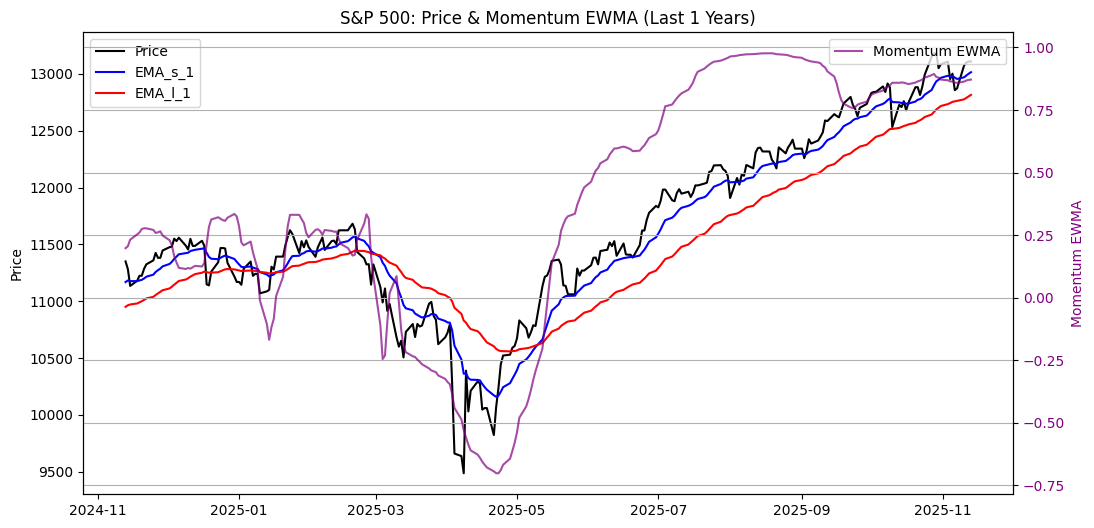

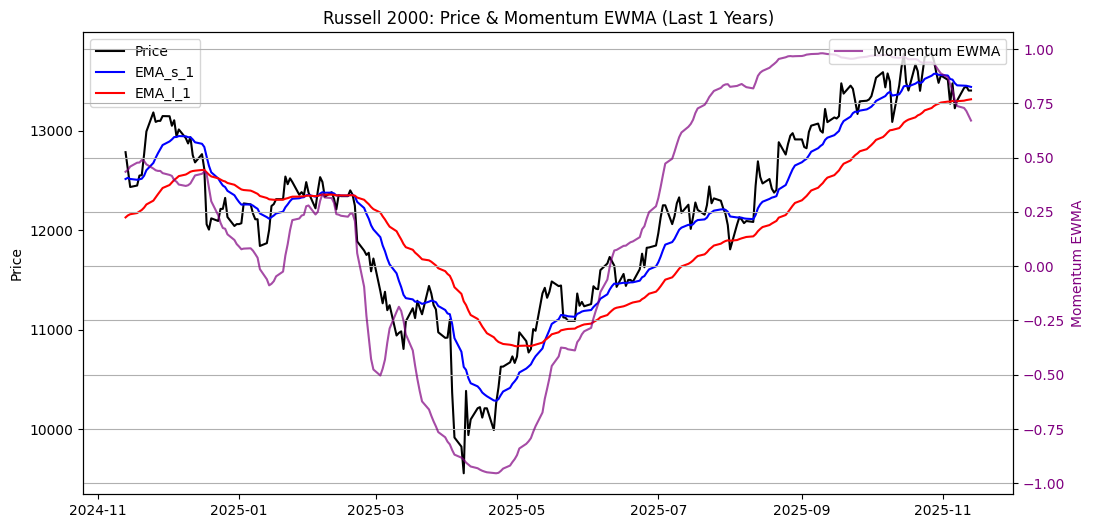

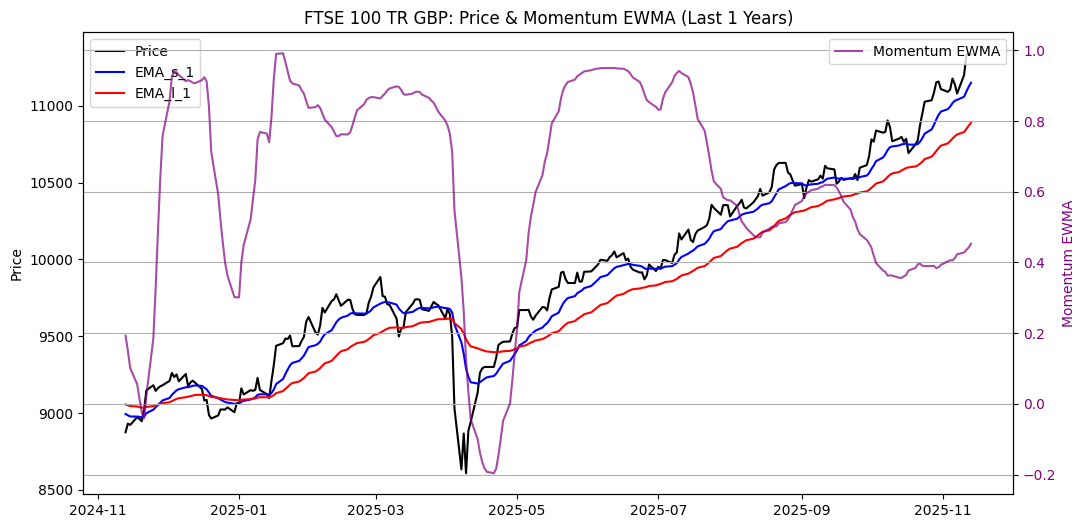

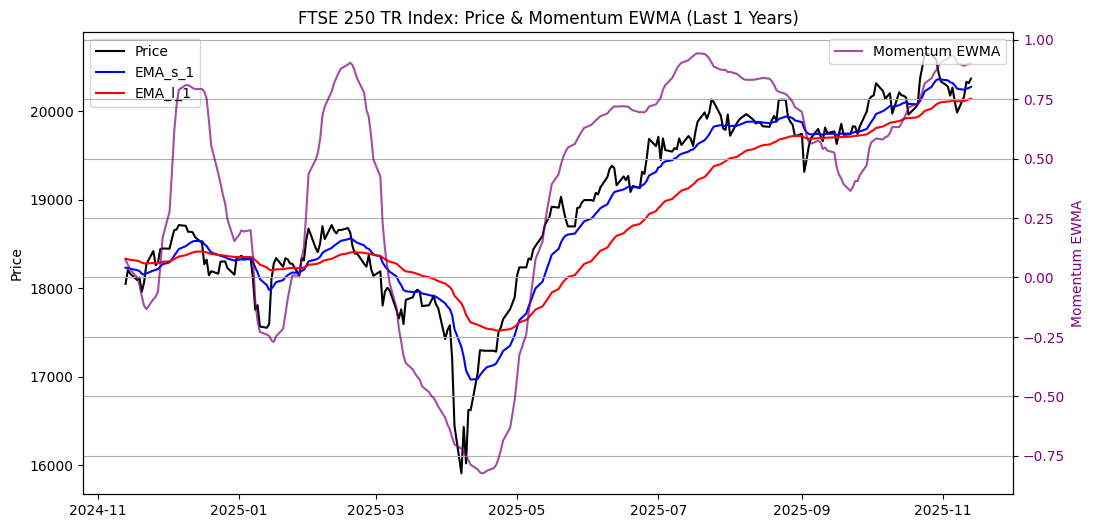

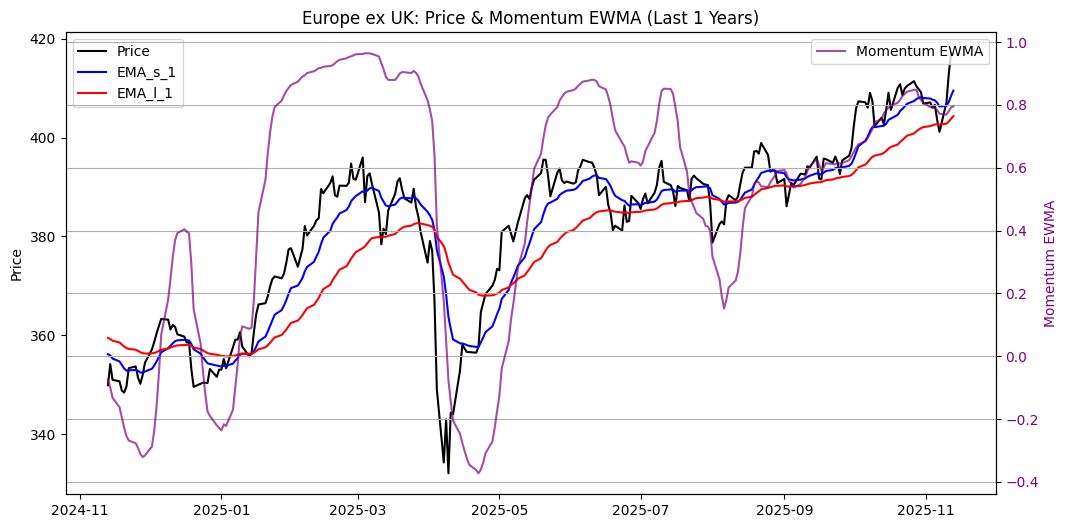

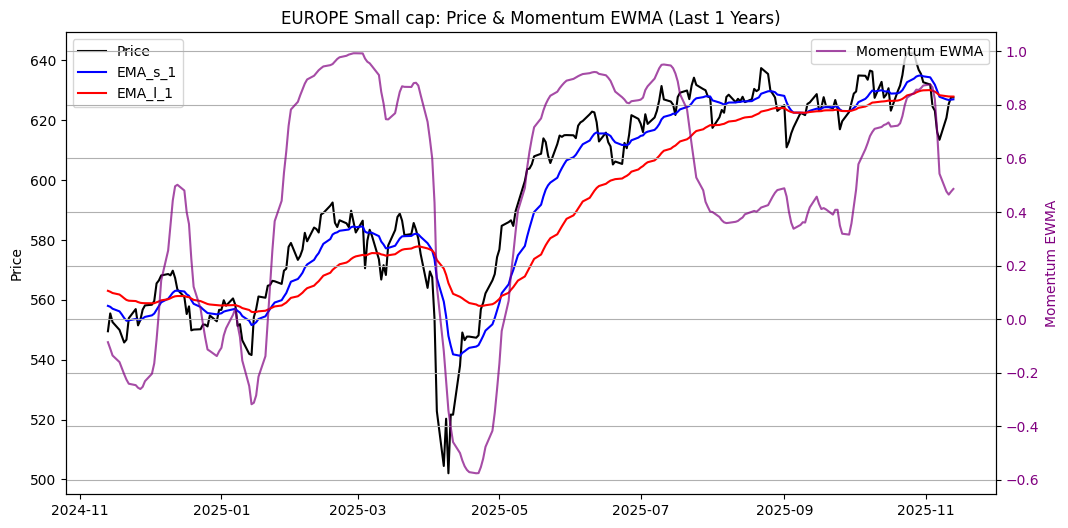

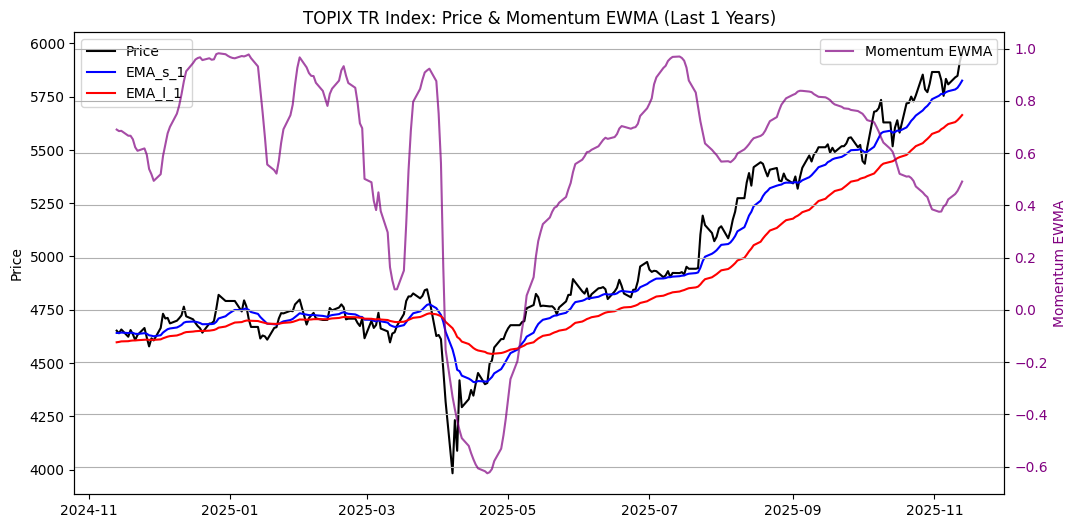

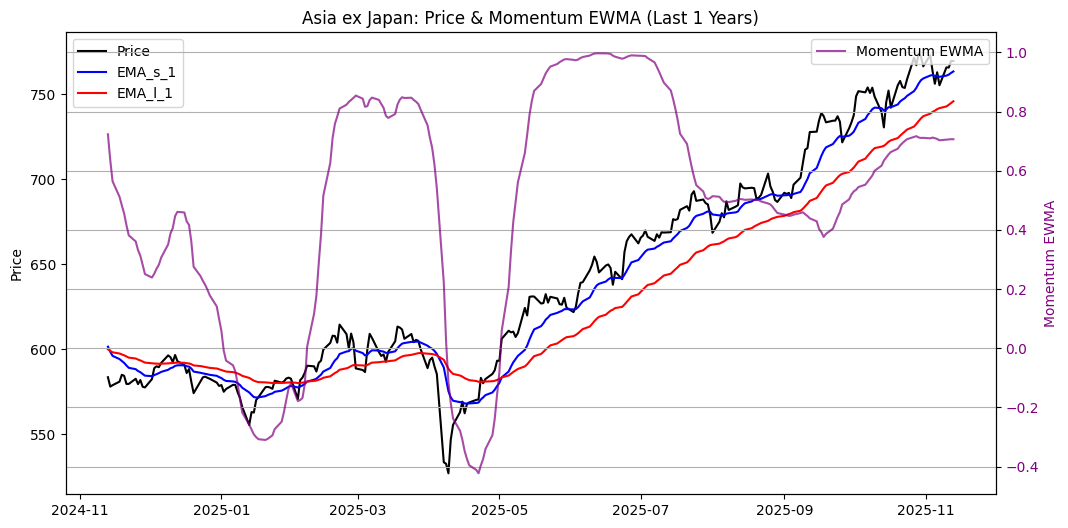

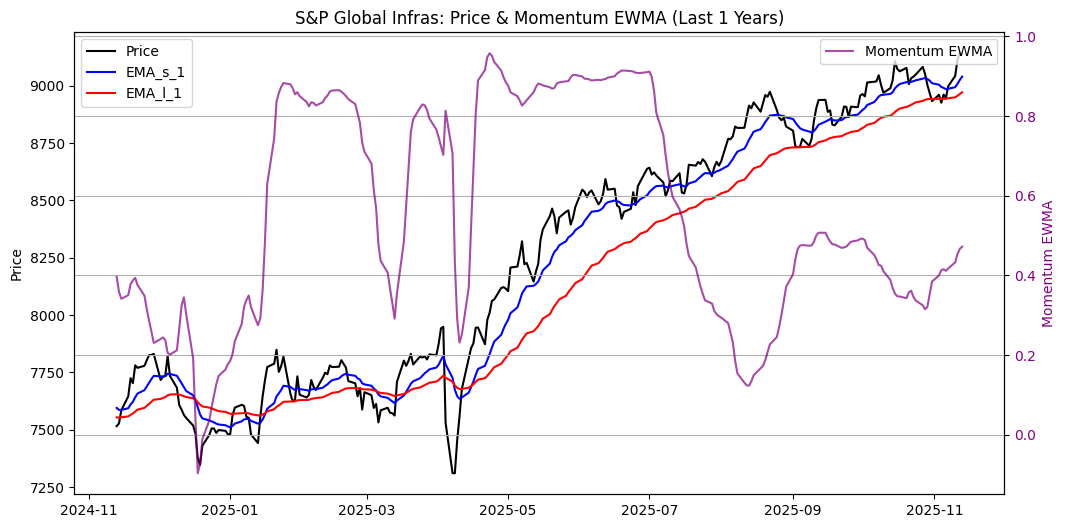

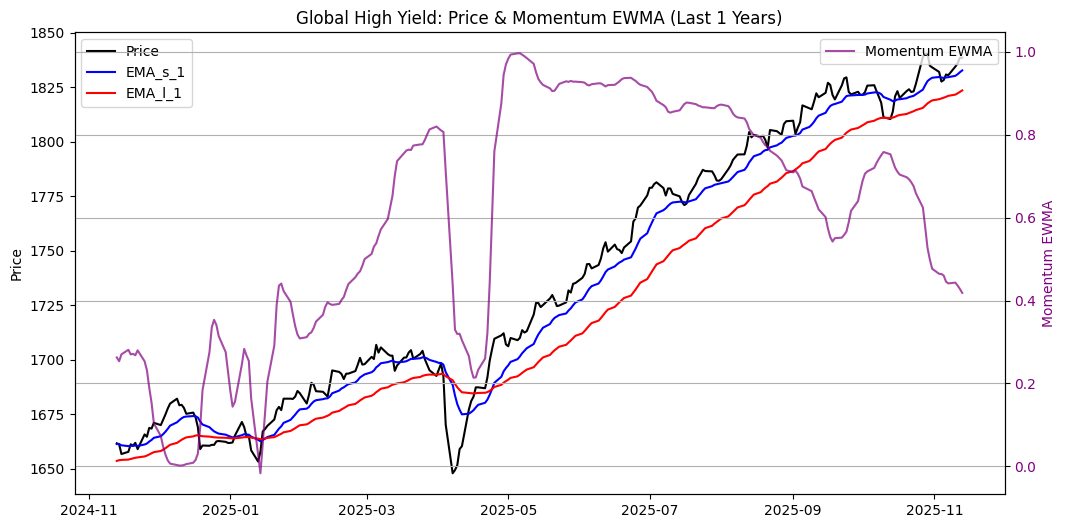

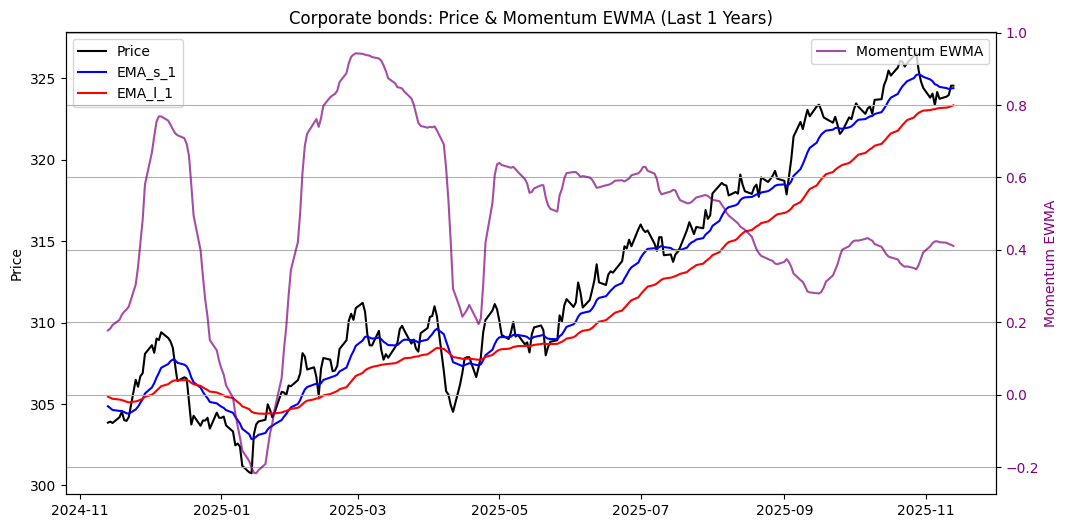

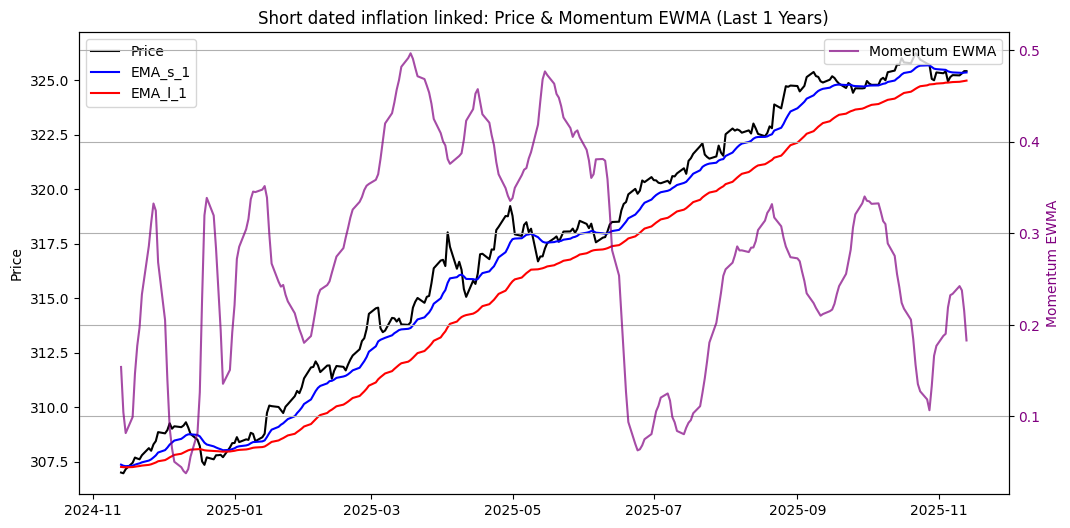

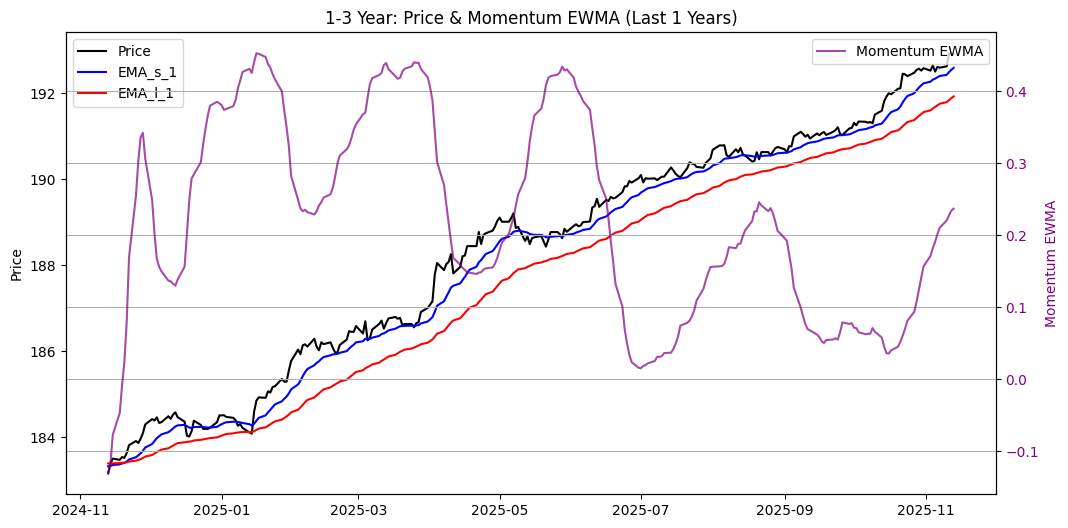

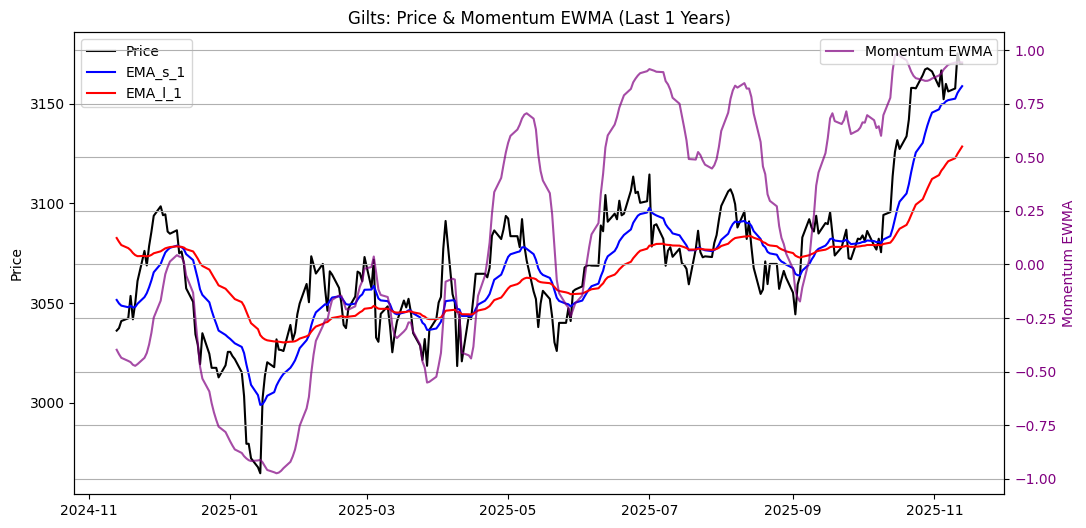

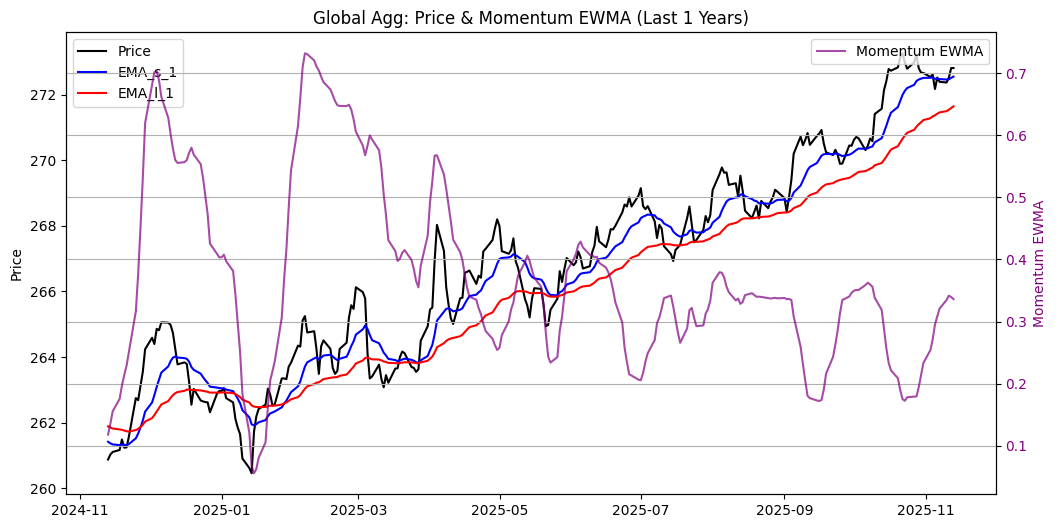

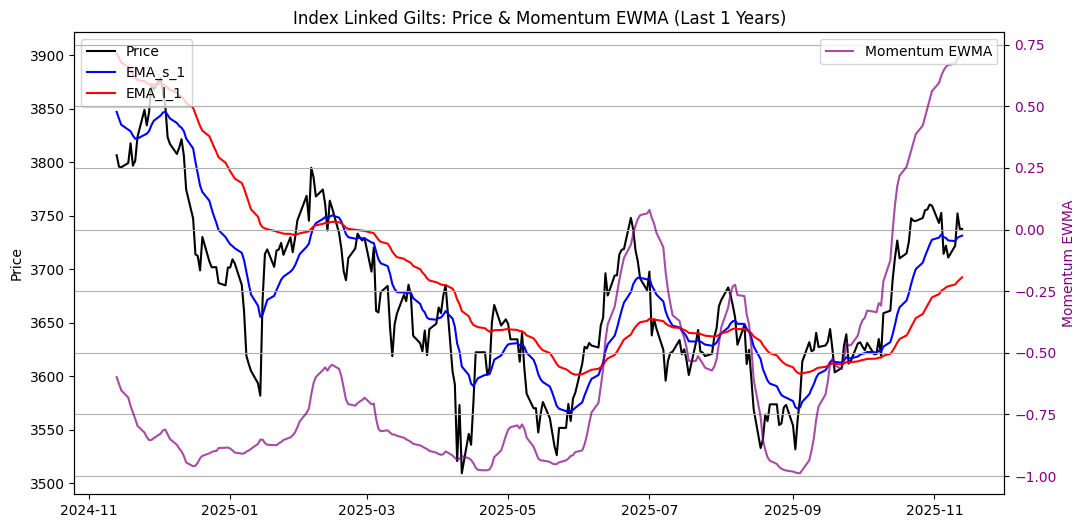

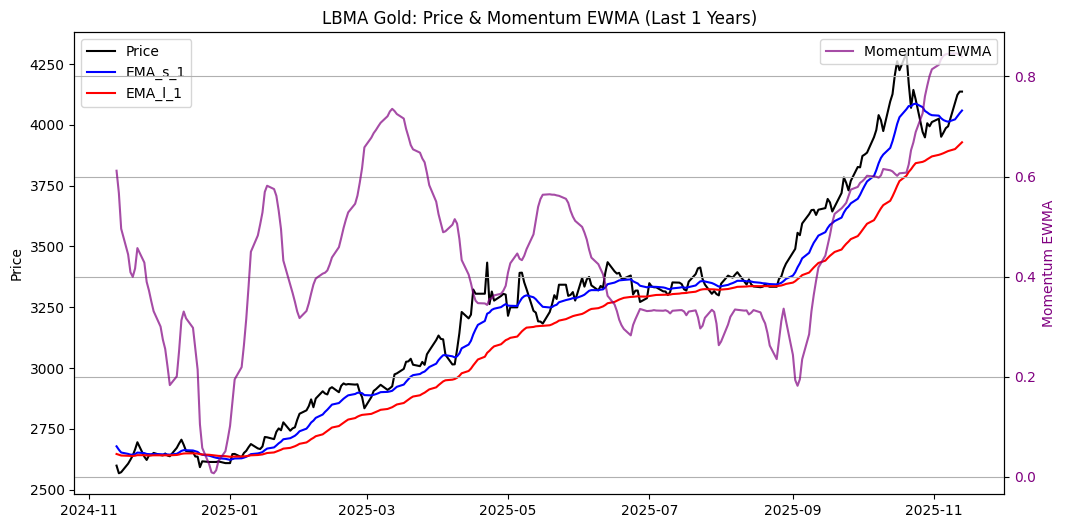

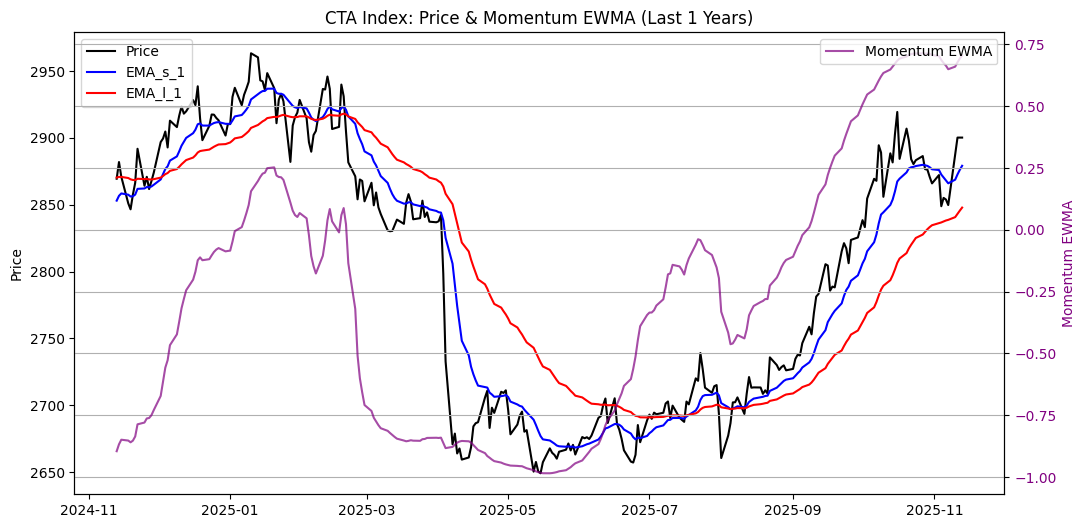

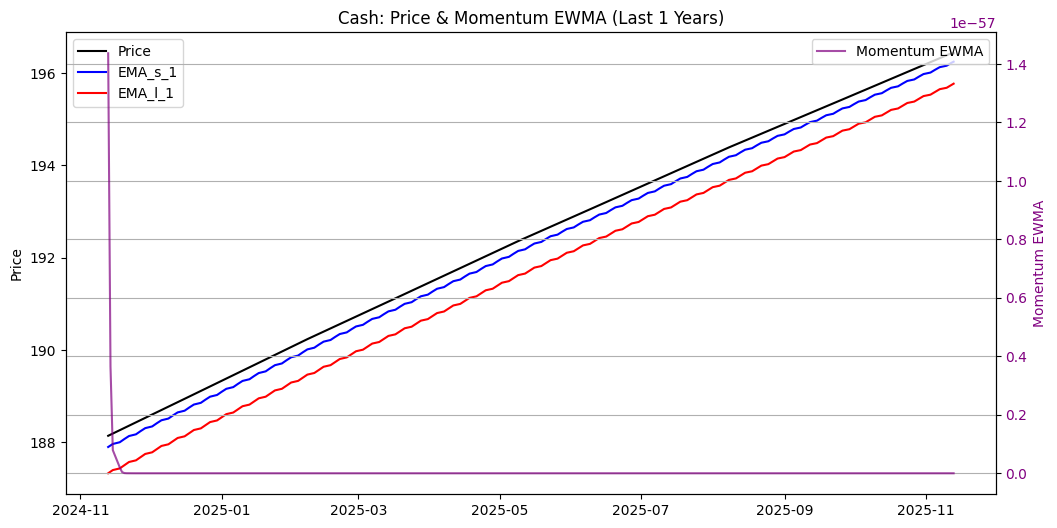

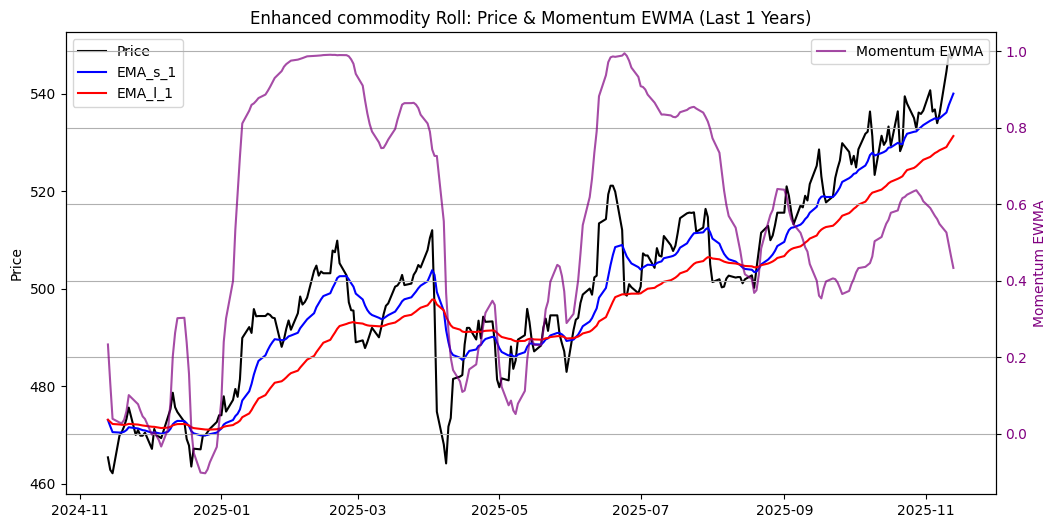

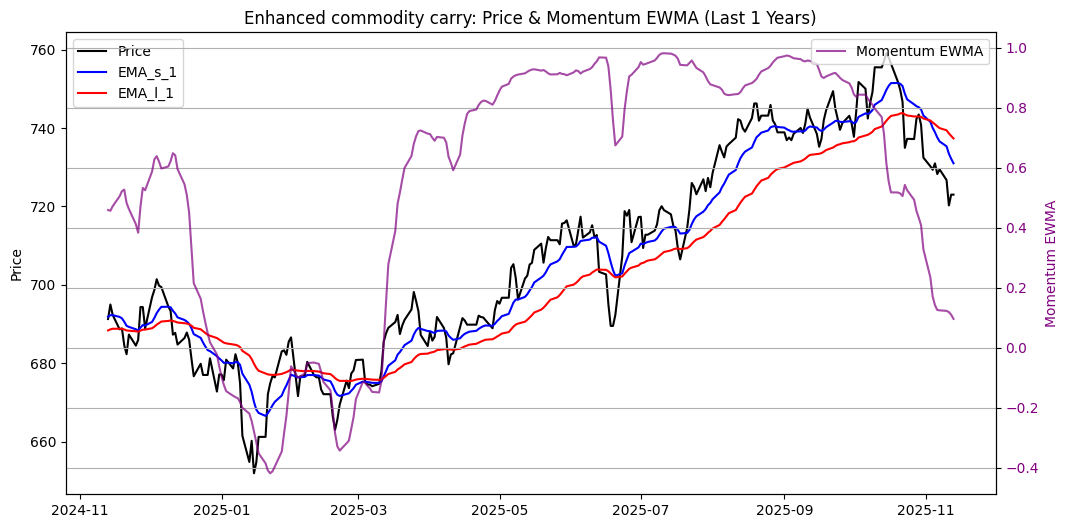

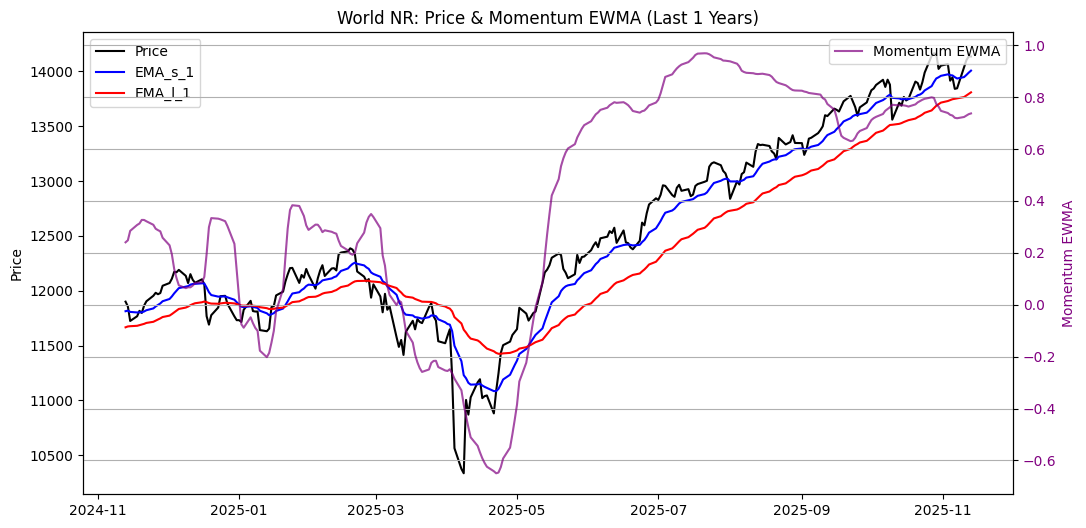

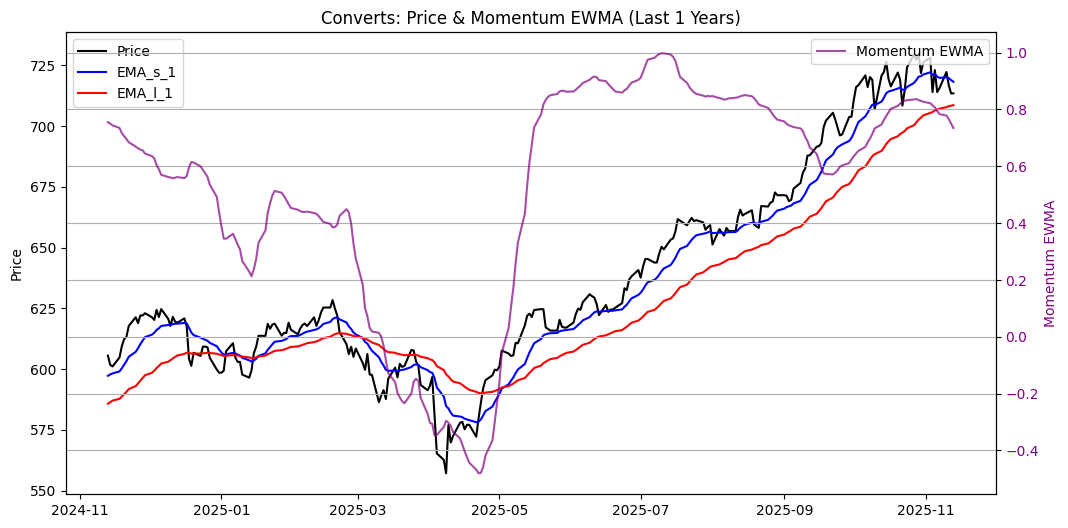

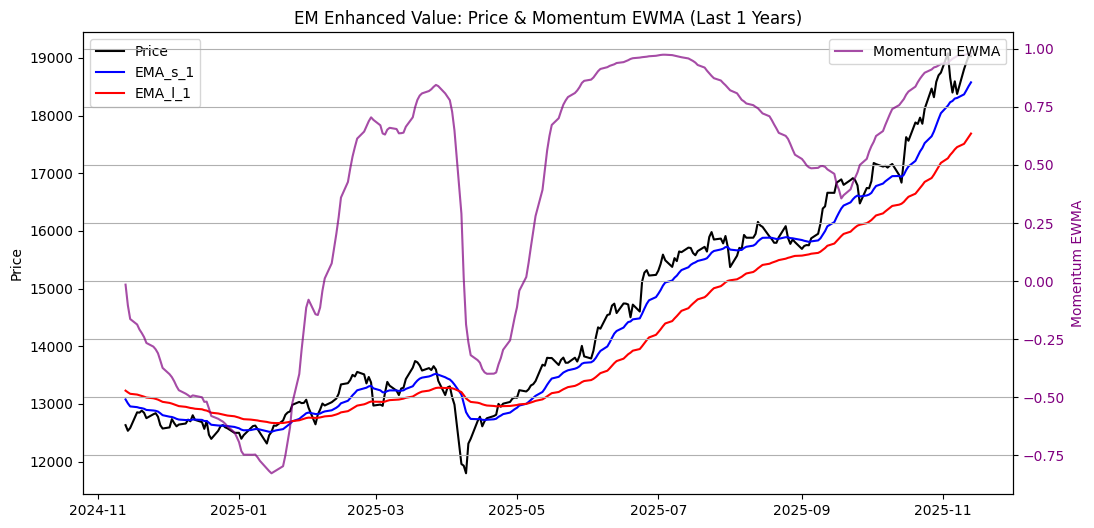

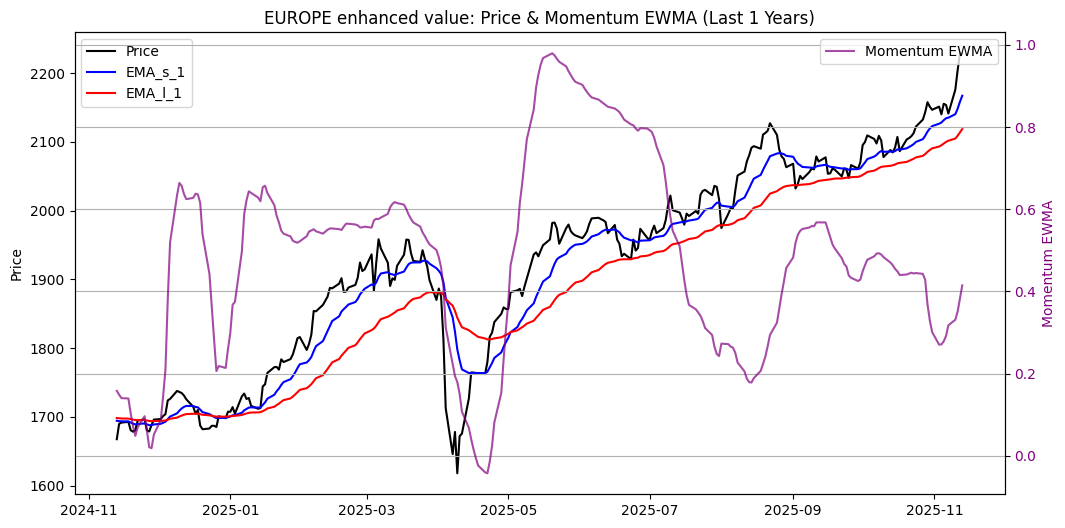

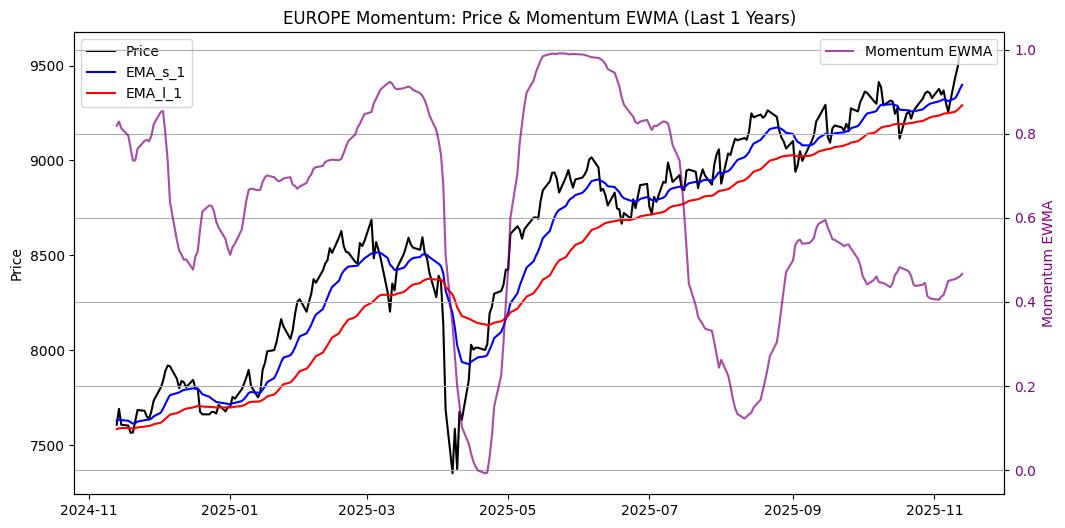

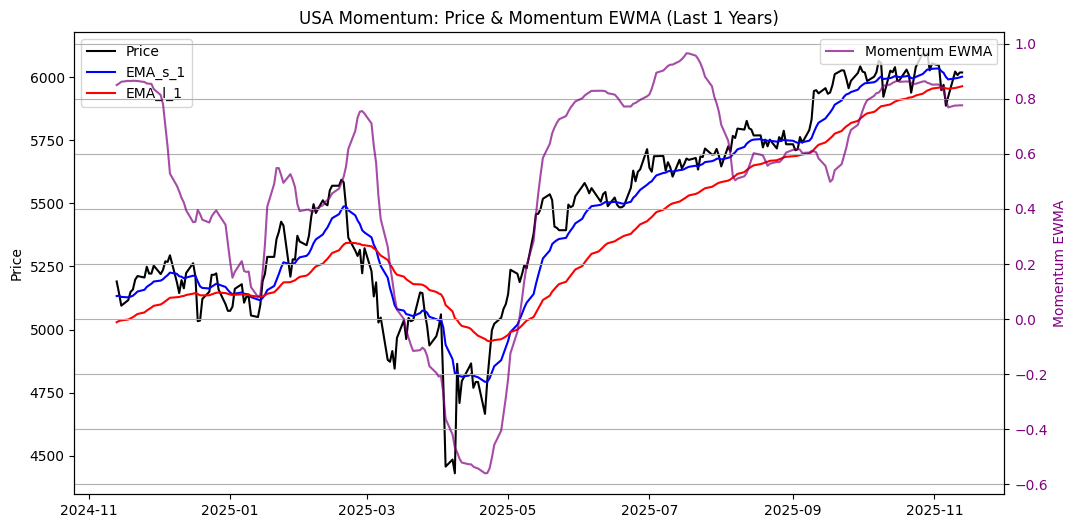

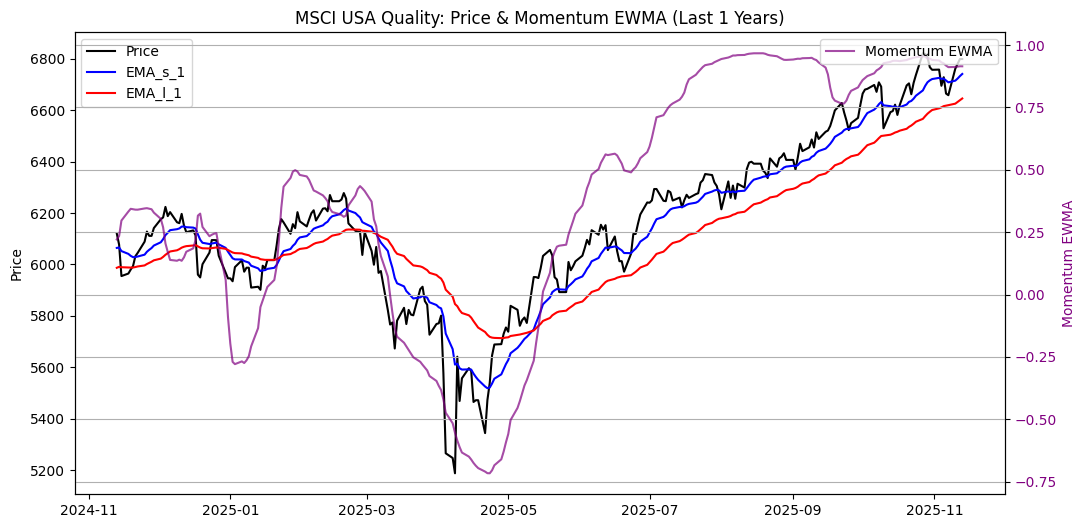

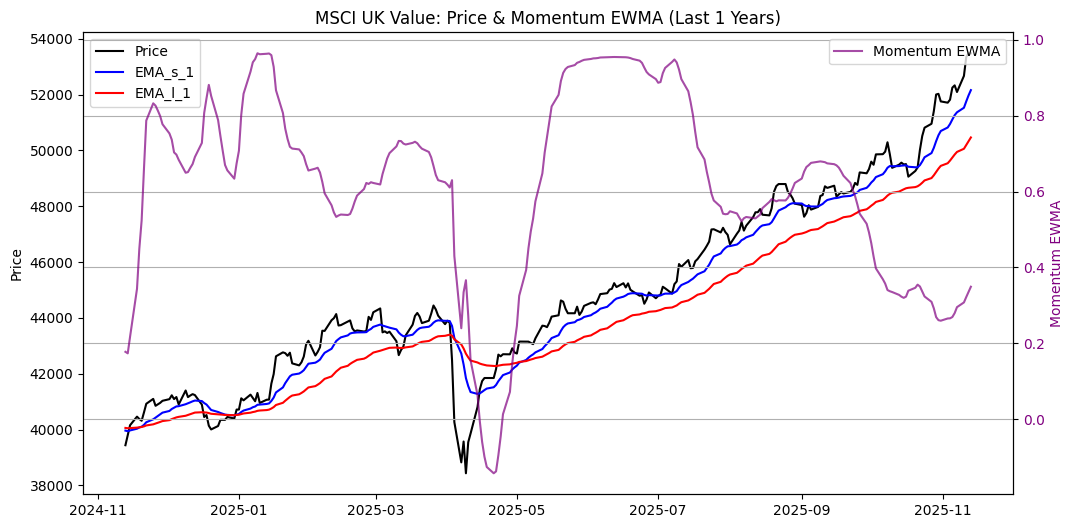

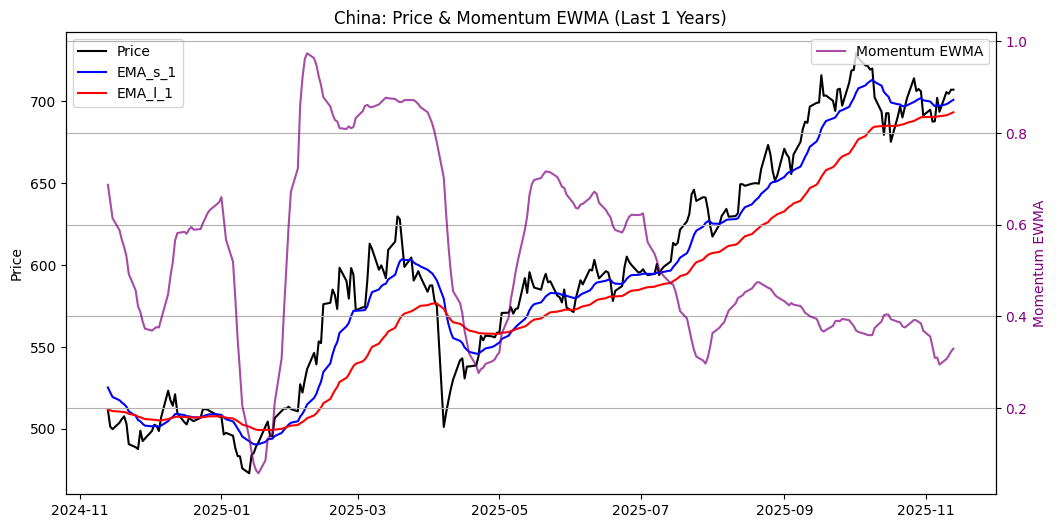

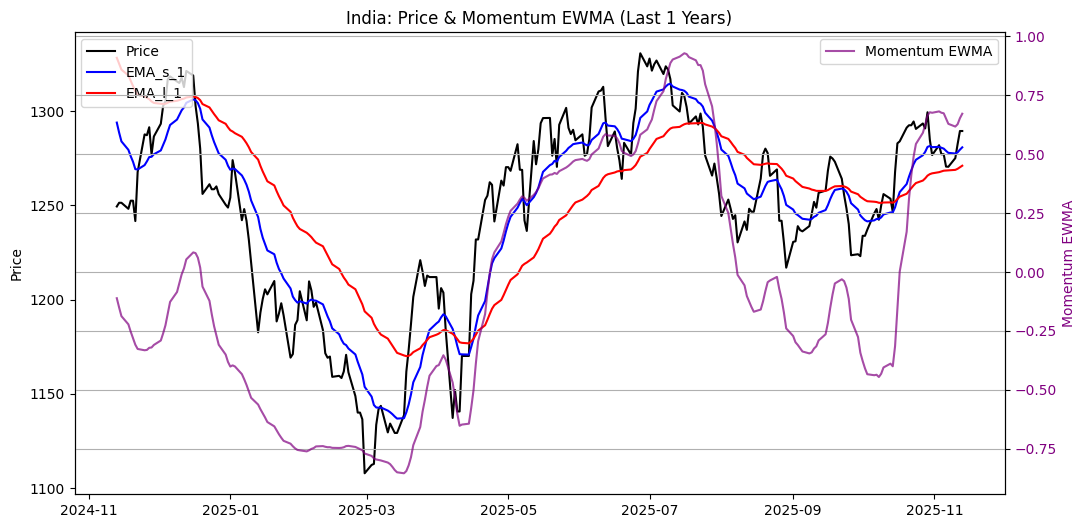

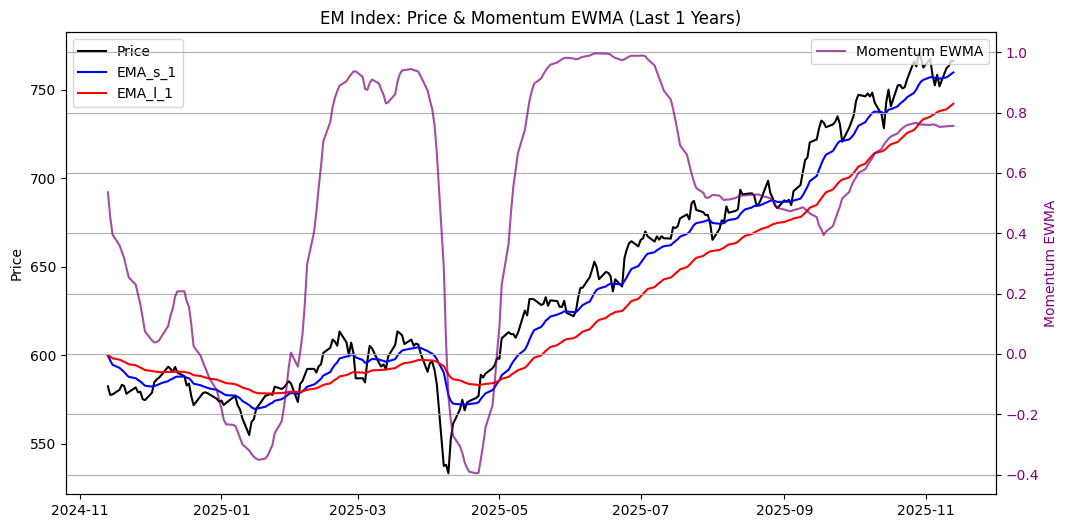

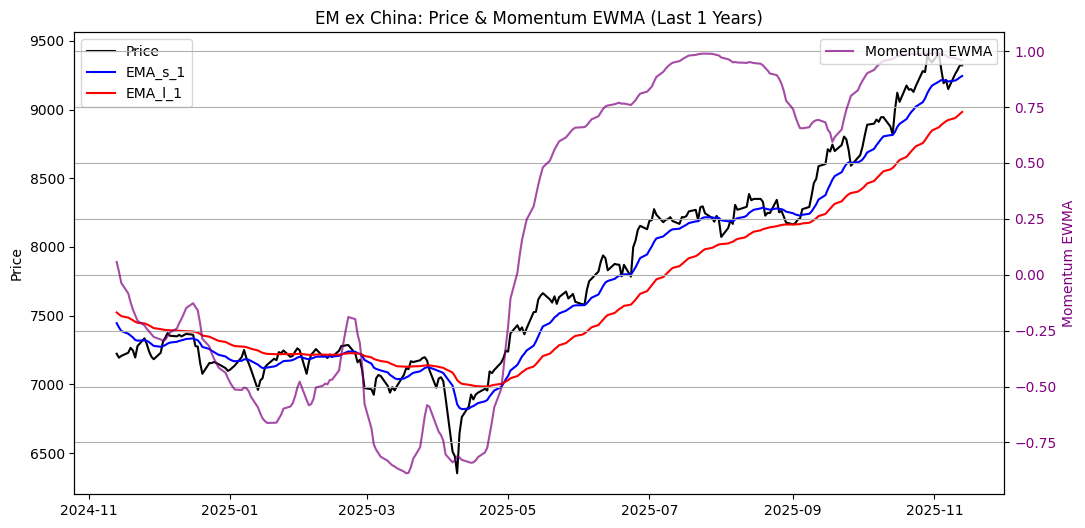

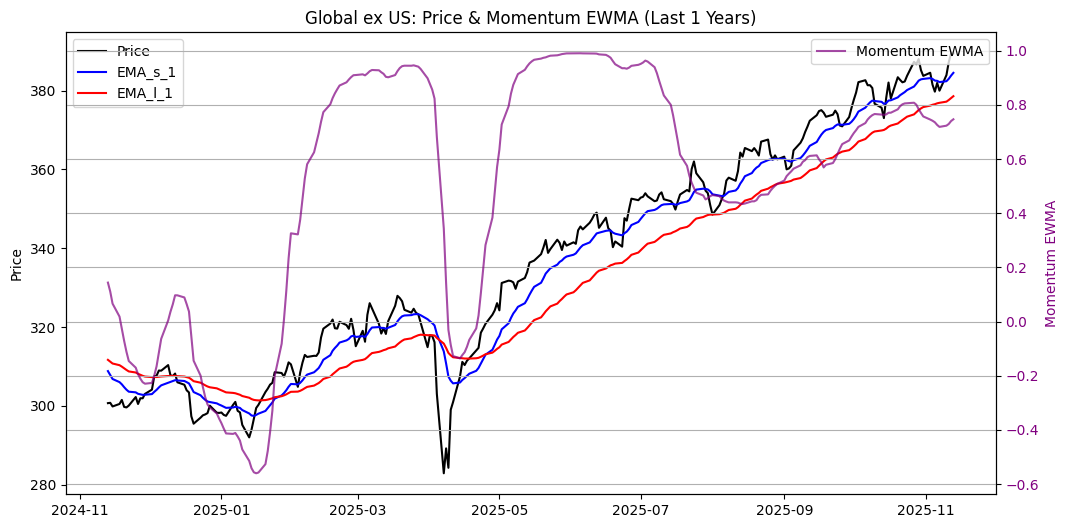

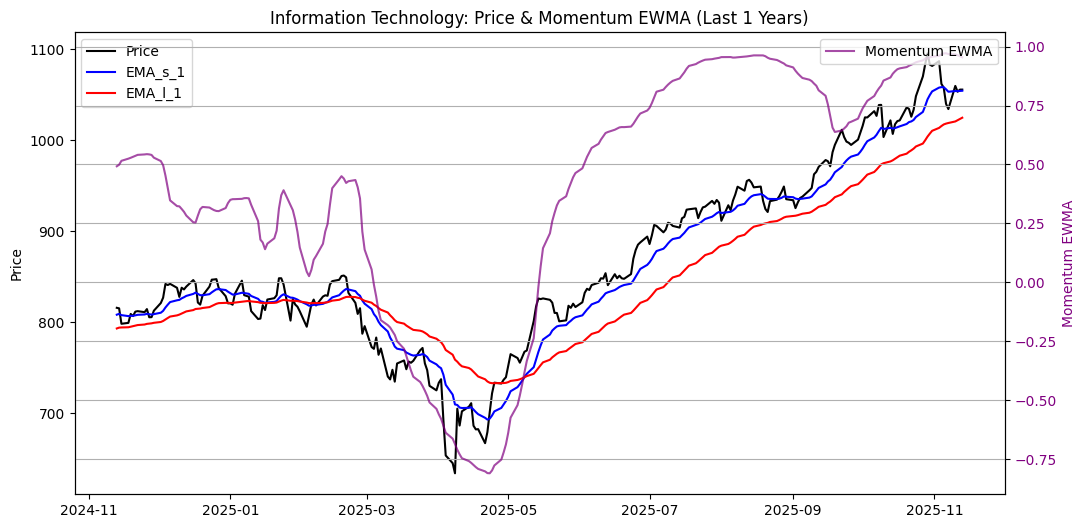

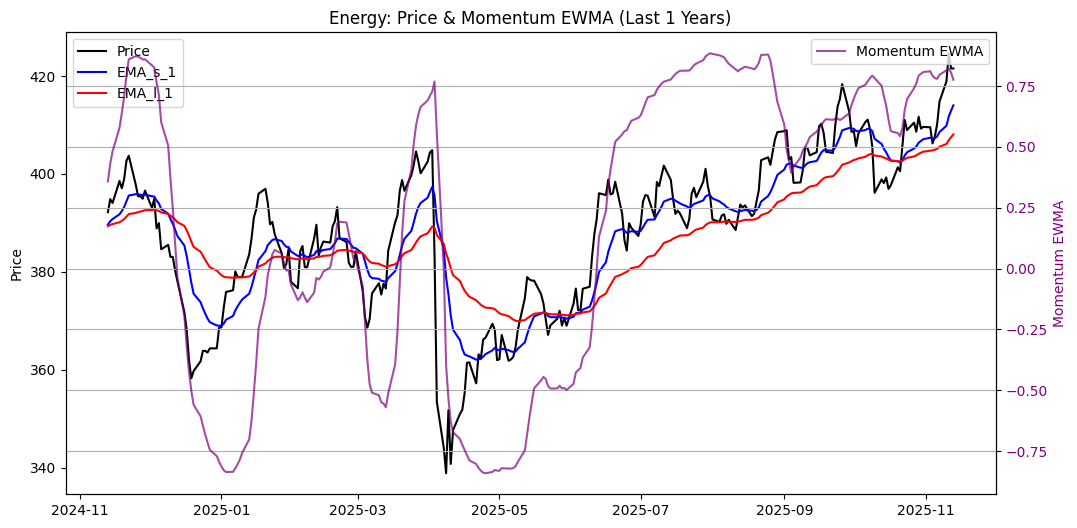

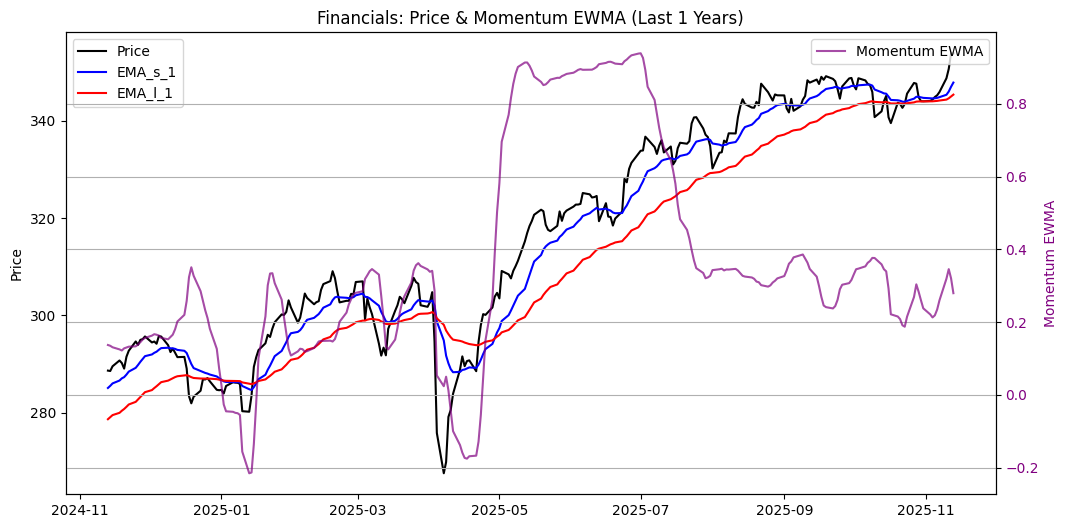

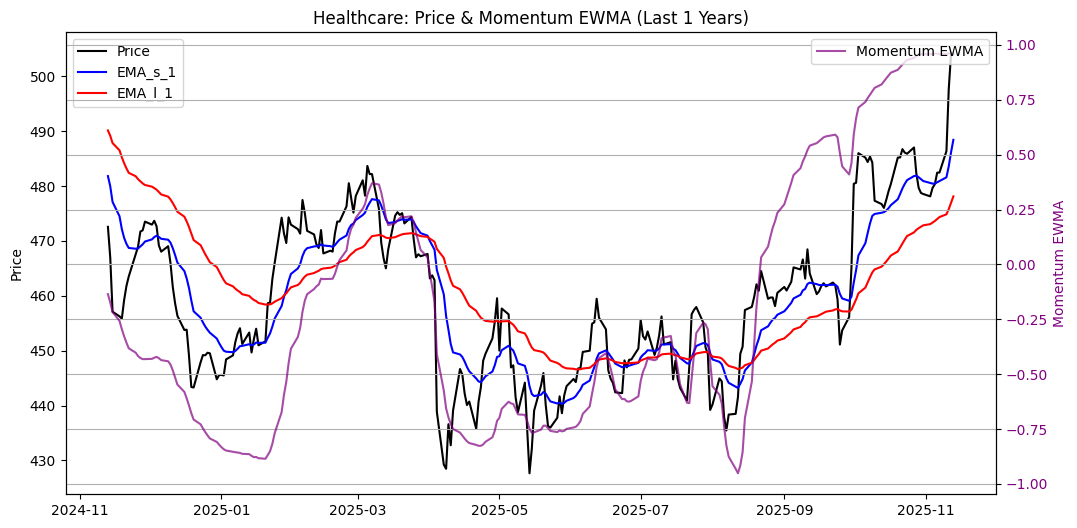

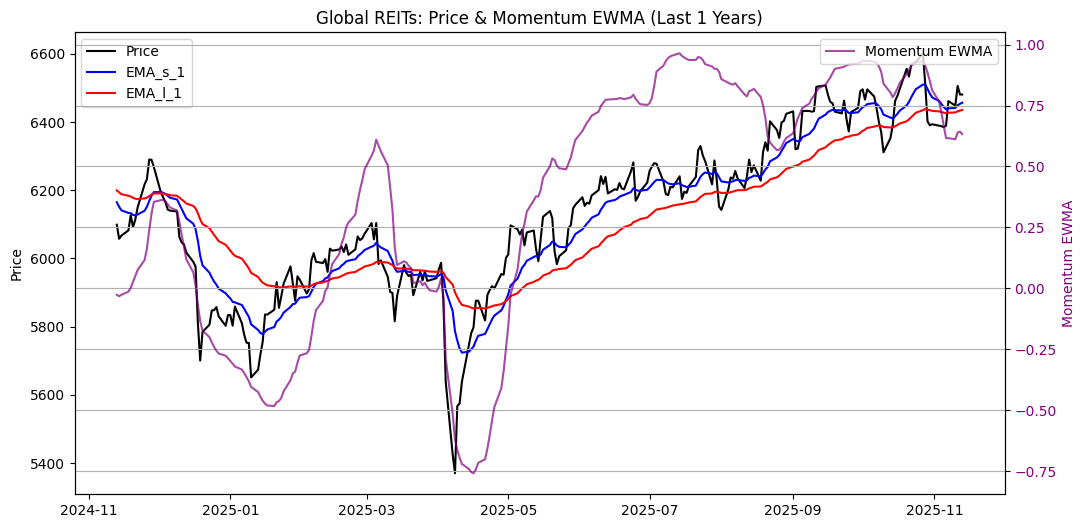

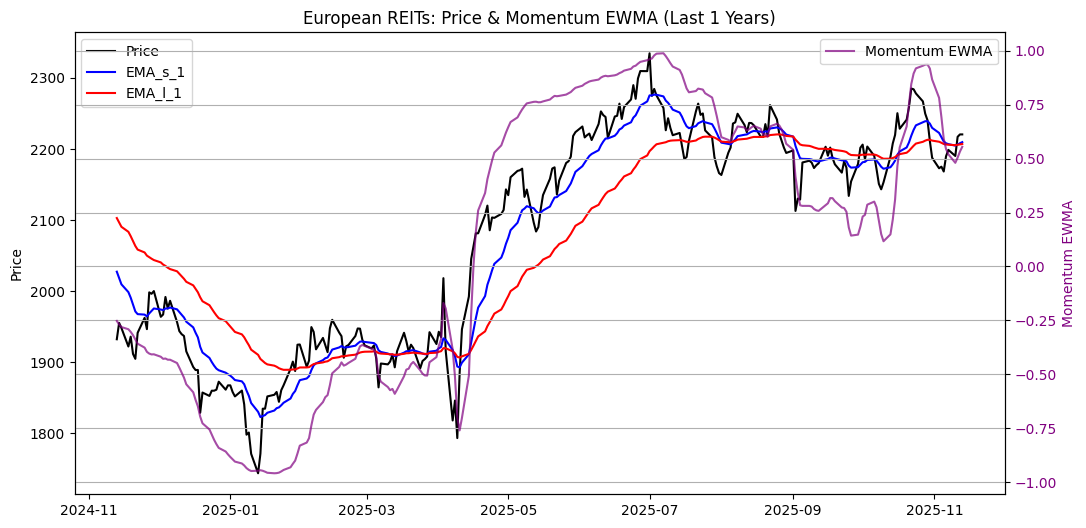

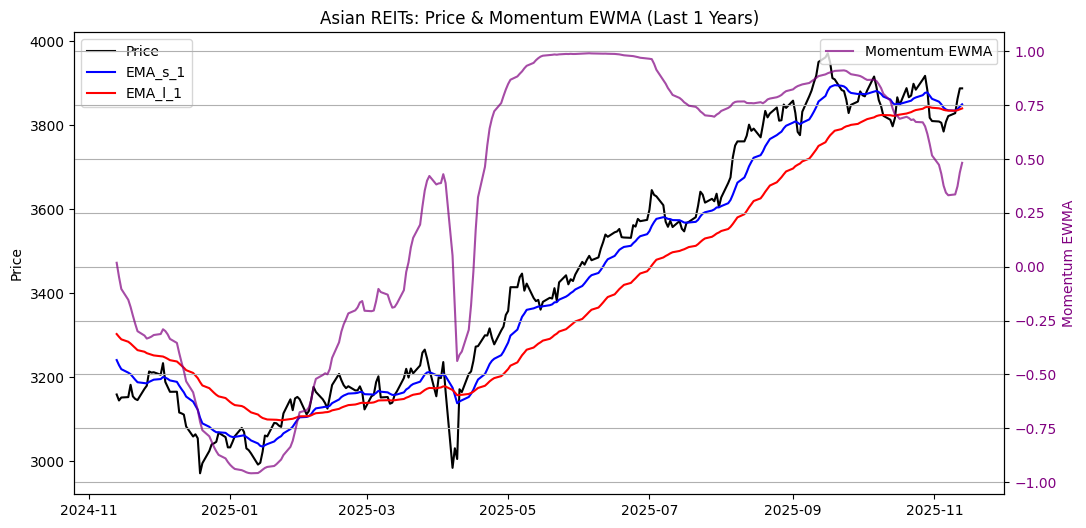

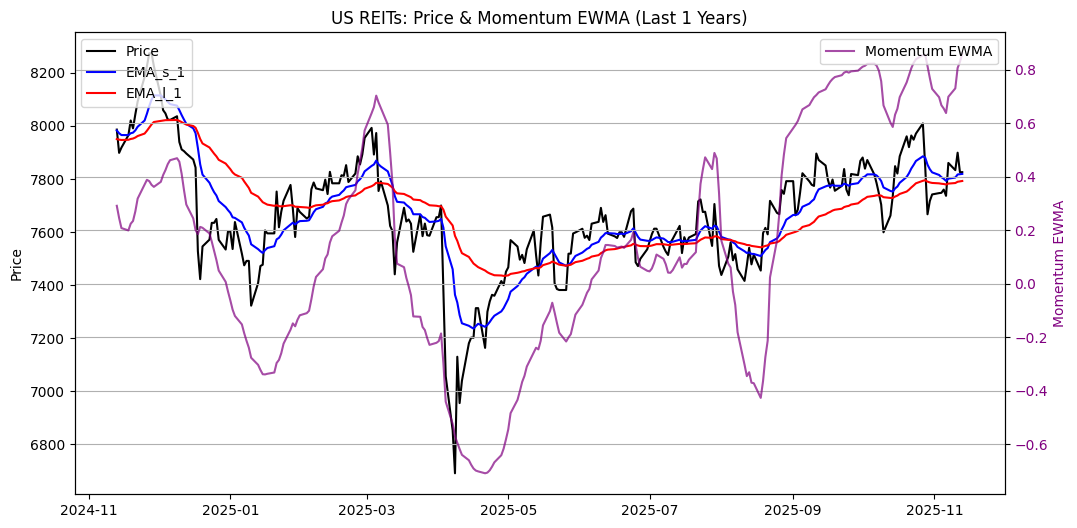

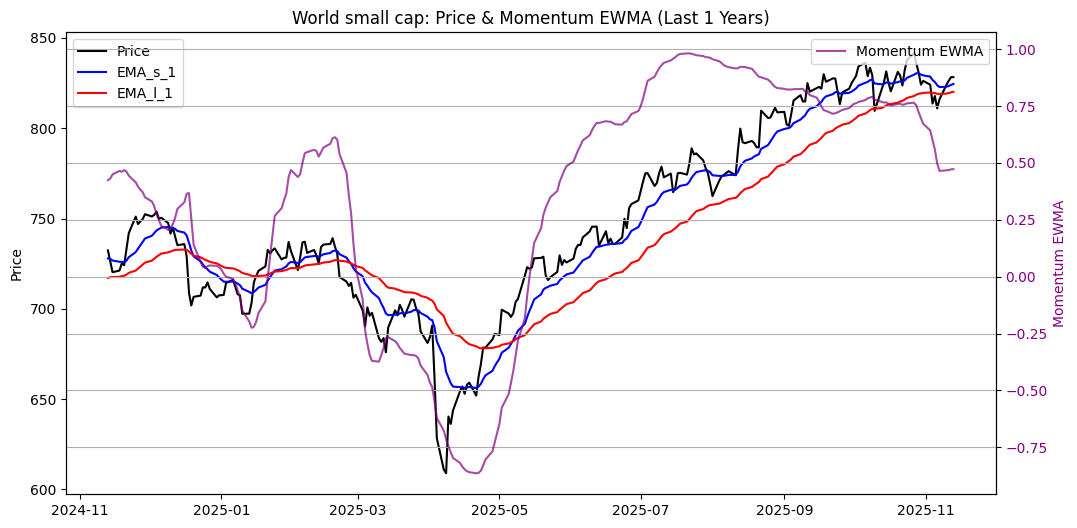

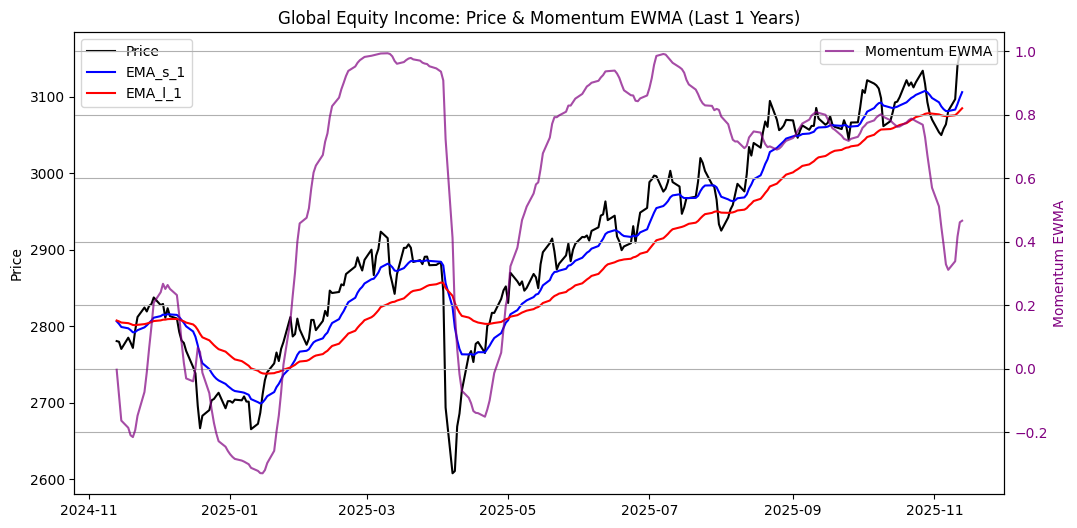

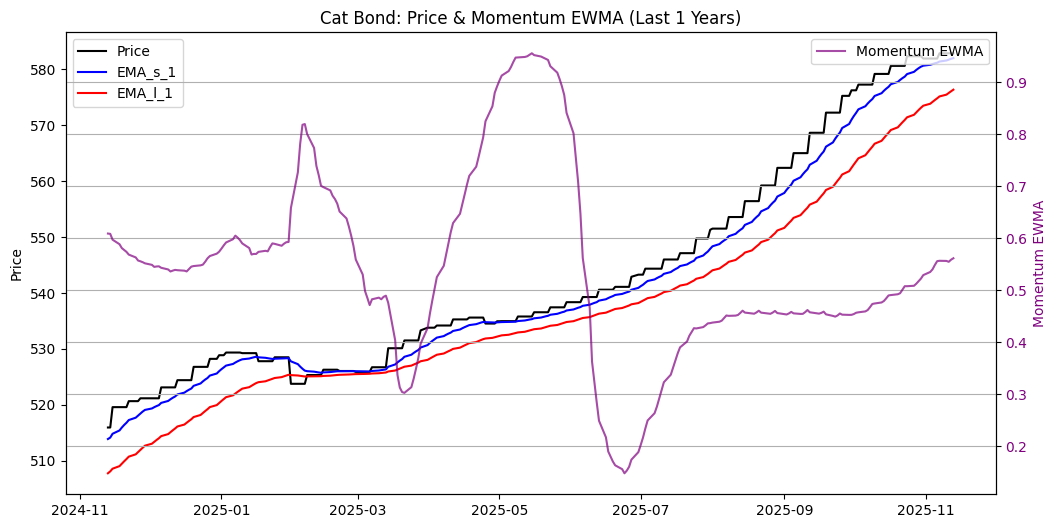

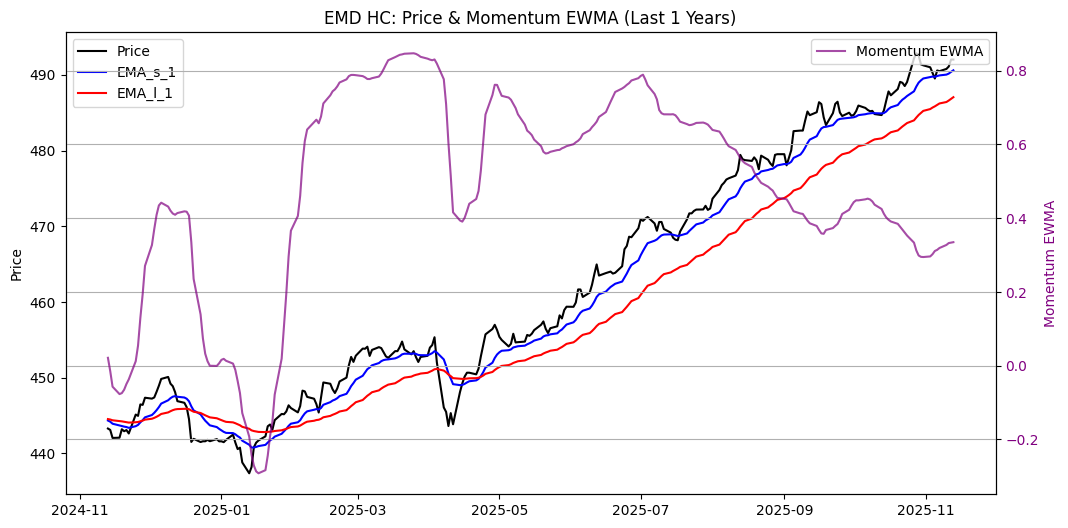

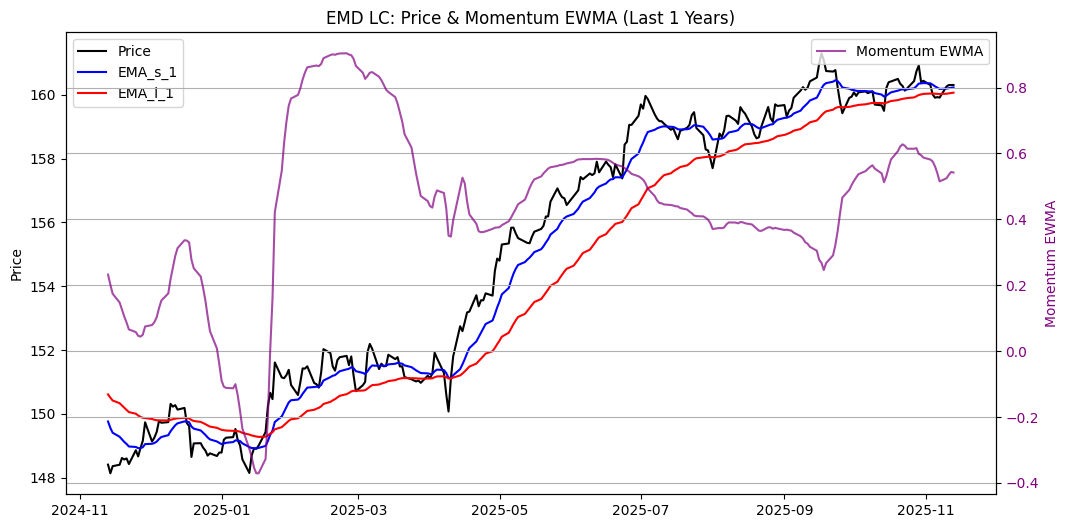

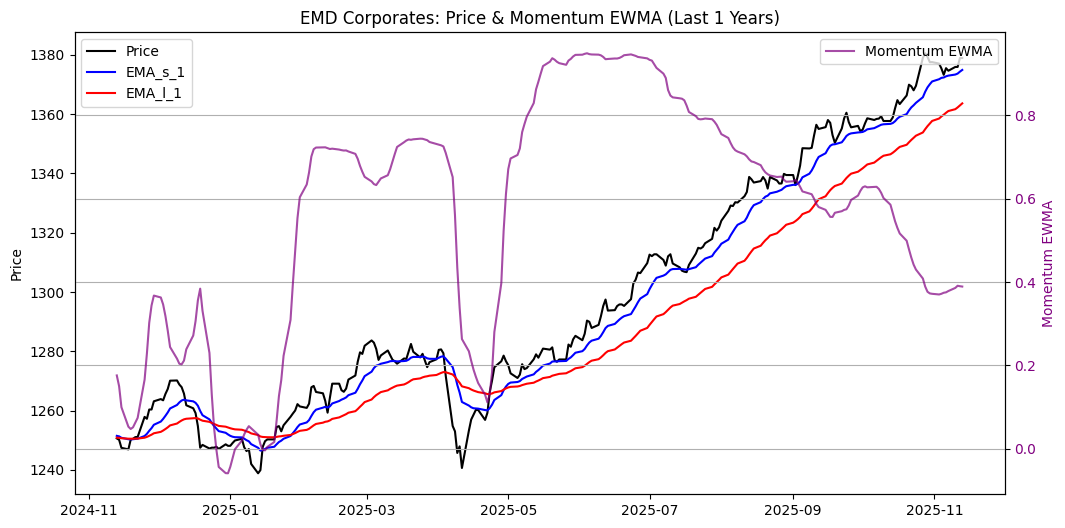

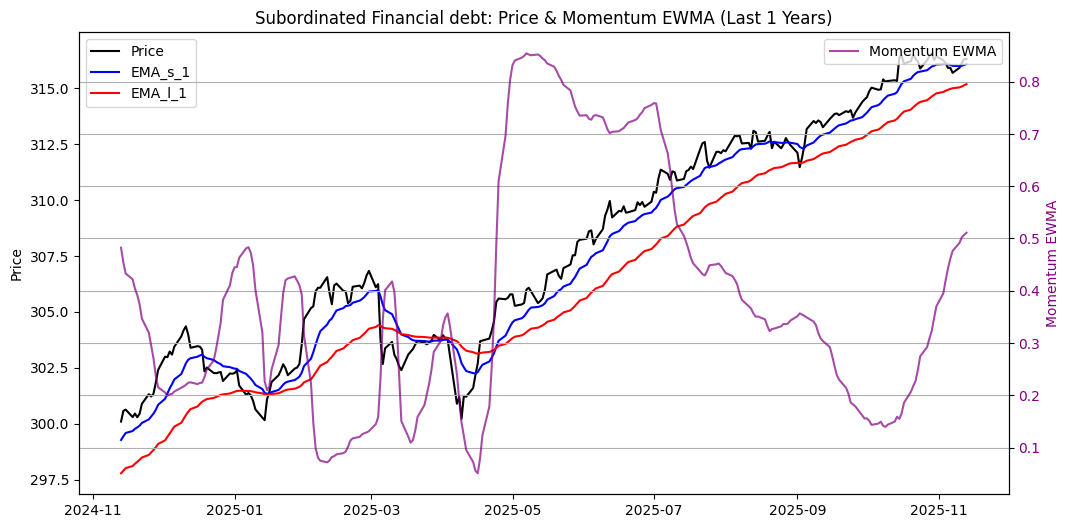

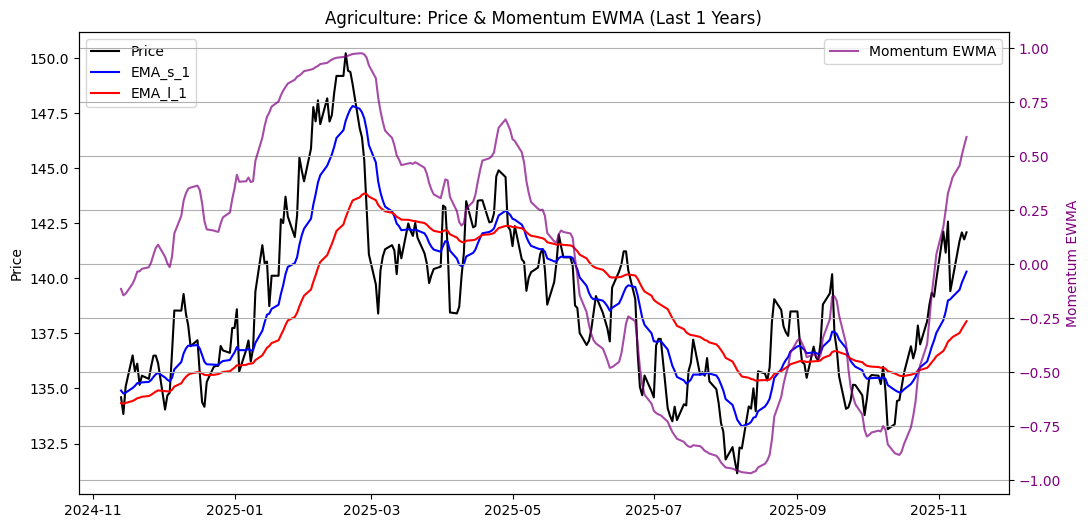

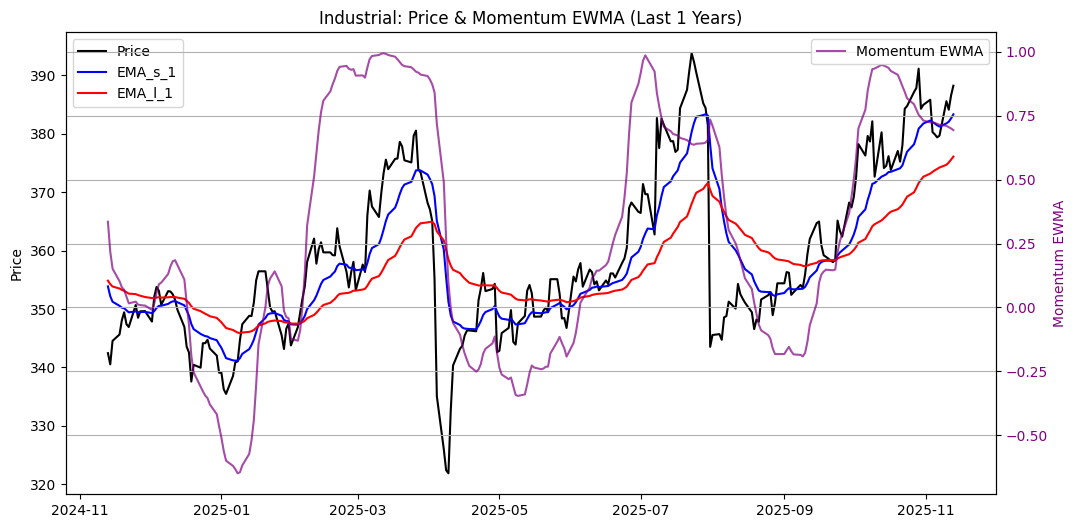

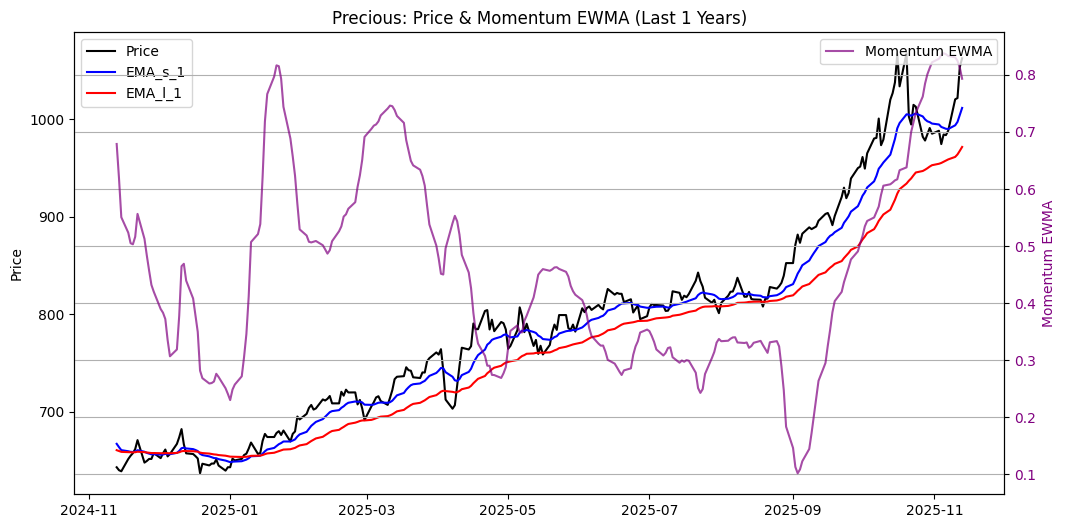

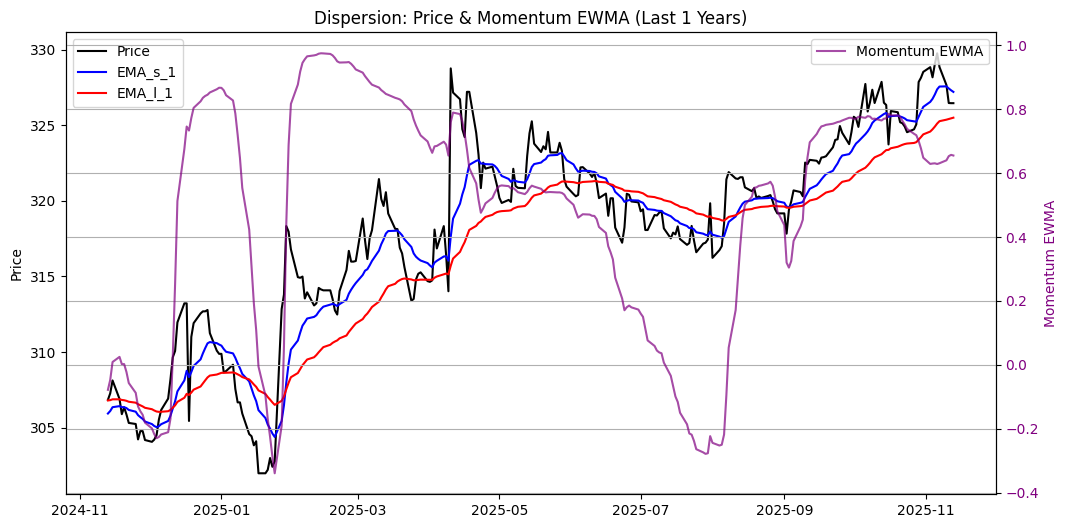

In [9]:
for asset, df in cta_results.items():
    df = df.dropna()
    if df.empty or 'price' not in df or 'signal' not in df:
        continue
    last_3_years = df.index >= (df.index.max() - pd.DateOffset(years=1))
    df_recent = df.loc[last_3_years]
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.plot(df_recent.index, df_recent['price'], label='Price', color='black')
    ax1.plot(df_recent.index, df_recent['EMA_s_1'], label='EMA_s_1', color='blue')
    ax1.plot(df_recent.index, df_recent['EMA_l_1'], label='EMA_l_1', color='red')
    ax1.set_ylabel('Price', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx()
    ax2.plot(df_recent.index, df_recent['signal'], label='Momentum EWMA', color='purple', alpha=0.7)
    ax2.set_ylabel('Momentum EWMA', color='purple')
    ax2.tick_params(axis='y', labelcolor='purple')
    ax2.legend(loc='upper right')
    plt.title(f'{asset}: Price & Momentum EWMA (Last 1 Years)')
    plt.grid(True)
#    plt.show()


In [10]:
# Create a DataFrame with asset names as index, latest signal, and changes over 1M, 3M, 1Y
signals_df = pd.DataFrame([
    {
        'Asset': asset,
        'Latest Signal': round(df['signal'].iloc[-1], 2),
        '1M Change': round(df['signal'].iloc[-1] - df['signal'].iloc[-22], 2),
        '3M Change': round(df['signal'].iloc[-1] - df['signal'].iloc[-63], 2),
        '1Y Change': round(df['signal'].iloc[-1] - df['signal'].iloc[-253], 2)
    }
    for asset, df in cta_results.items()
]).set_index('Asset')

signals_df.to_csv('cta_signals_summary.csv')

In [24]:
import pandas as pd
from dash import Dash, dcc, html, Input, Output, State
import plotly.graph_objs as go
from datetime import timedelta

assets = sorted(list(cta_results.keys()))
min_date = min(df.index.min() for df in cta_results.values()).date()
max_date = max(df.index.max() for df in cta_results.values()).date()

period_buttons = [
    {'label': '1M', 'value': '1M'},
    {'label': '3M', 'value': '3M'},
    {'label': '1Y', 'value': '1Y'},
    {'label': '3Y', 'value': '3Y'},
    {'label': 'All', 'value': 'ALL'}
]

app = Dash(__name__)
app.layout = html.Div([
    html.Div([
        dcc.Dropdown(
            id='asset-dropdown',
            options=[{'label': a, 'value': a} for a in assets],
            value=assets[0] if assets else None,
            clearable=False,
            style={'width': '320px', 'display': 'inline-block', 'marginRight': '20px'}
        ),
        html.Div([
            html.Label("Quick Period:"),
            dcc.RadioItems(
                id='period-radio',
                options=period_buttons,
                value='ALL',
                labelStyle={'display': 'inline-block', 'marginRight': '10px'}
            )
        ], style={'display': 'inline-block', 'marginLeft': '20px'})
    ], style={'textAlign': 'center', 'padding': '18px'}),

    html.Div(dcc.Graph(id='main-chart', config={'displayModeBar': True}), style={'maxWidth': '900px', 'margin': '0 auto'})
], style={'fontFamily': 'Arial, sans-serif'})

@app.callback(
    Output('main-chart', 'figure'),
    Input('asset-dropdown', 'value'),
    Input('period-radio', 'value')
)
def update_chart(asset, period):
    if asset is None or asset not in cta_results:
        return go.Figure(layout={'title': "No asset selected"})
    df = cta_results[asset].dropna().copy()
    df = df.reset_index().rename(columns={'index': 'Date'})
    df['Date'] = pd.to_datetime(df['Date'])
    last_date = df['Date'].max()
    if period == '1M':
        start_date = last_date - pd.DateOffset(days=30)
    elif period == '3M':
        start_date = last_date - pd.DateOffset(days=90)
    elif period == '1Y':
        start_date = last_date - pd.DateOffset(days=365)
    elif period == '3Y':
        start_date = last_date - pd.DateOffset(days=365*3)
    else:
        start_date = df['Date'].min()
    df = df[df['Date'] >= start_date]
    if df.empty:
        return go.Figure(layout={'title': f"No data for {asset} in selected range"})
    price_min, price_max = df['price'].min(), df['price'].max()
    signal_min, signal_max = df['signal'].min(), df['signal'].max()
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['Date'], y=df['price'], mode='lines', name='Price', line=dict(color='black')))
    fig.add_trace(go.Scatter(x=df['Date'], y=df['EMA_s_1'], mode='lines', name='Short MA', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=df['Date'], y=df['EMA_l_1'], mode='lines', name='Long MA', line=dict(color='red')))
    fig.add_trace(go.Scatter(x=df['Date'], y=df['signal'], mode='lines', name='Signal', line=dict(color='purple', dash='dot'), yaxis='y2'))
    fig.update_layout(
        title=f"{asset}: Price, MAs & Signal",
        xaxis_title='Date',
        yaxis=dict(title='Price / MA', range=[price_min, price_max], autorange=False),
        yaxis2=dict(title='Signal', overlaying='y', side='right', showgrid=False, range=[signal_min, signal_max], autorange=False),
        legend=dict(x=0, y=1.1, orientation='h'),
        transition_duration=250
    )
    return fig

if __name__ == '__main__':
    app.run(debug=True, port=8050)

In [39]:
import pandas as pd
from dash import Dash, dcc, html, Input, Output, State, dash_table
import plotly.graph_objs as go
from datetime import timedelta

assets = sorted(list(cta_results.keys()))
min_date = min(df.index.min() for df in cta_results.values()).date()
max_date = max(df.index.max() for df in cta_results.values()).date()

period_buttons = [
    {'label': '1M', 'value': '1M'},
    {'label': '3M', 'value': '3M'},
    {'label': '1Y', 'value': '1Y'},
    {'label': '3Y', 'value': '3Y'},
    {'label': 'All', 'value': 'ALL'}
]

# Prepare signals_df for table display
signals_df = pd.DataFrame([
    {
        'Asset': asset,
        'Latest Signal': round(df['signal'].iloc[-1], 2),
        '1M Change': round(df['signal'].iloc[-1] - df['signal'].iloc[-22], 2),
        '3M Change': round(df['signal'].iloc[-1] - df['signal'].iloc[-63], 2),
        '1Y Change': round(df['signal'].iloc[-1] - df['signal'].iloc[-253], 2)
    }
    for asset, df in cta_results.items()
]).set_index('Asset').reset_index()

app = Dash(__name__)
app.layout = html.Div([
    html.Div([
        dcc.Dropdown(
            id='asset-dropdown',
            options=[{'label': a, 'value': a} for a in assets],
            value=assets[0] if assets else None,
            clearable=False,
            style={'width': '400px', 'display': 'inline-block', 'marginRight': '10px'}
        ),
        html.Div([
            html.Label("Quick Period:"),
            dcc.RadioItems(
                id='period-radio',
                options=period_buttons,
                value='ALL',
                labelStyle={'display': 'inline-block', 'marginRight': '10px'}
            )
        ], style={'display': 'inline-block', 'marginLeft': '20px'})
    ], style={'textAlign': 'center', 'padding': '18px'}),

    html.Div(dcc.Graph(id='main-chart', config={'displayModeBar': True}), style={'maxWidth': '900px', 'margin': '0 auto'}),
    html.Hr(),
    html.Div([
        dash_table.DataTable(
            id='signals-table',
            columns=[{"name": i, "id": i} for i in signals_df.columns],
            data=signals_df.to_dict('records'),
            sort_action='native',
            style_table={'width': '900px', 'margin': '0 auto'},
            style_cell={'textAlign': 'center'},
            style_header={'fontWeight': 'bold'}
        )
    ])
], style={'fontFamily': 'Arial, sans-serif'})

@app.callback(
    Output('main-chart', 'figure'),
    Input('asset-dropdown', 'value'),
    Input('period-radio', 'value')
)
def update_chart(asset, period):
    if asset is None or asset not in cta_results:
        return go.Figure(layout={'title': "No asset selected"})
    df = cta_results[asset].dropna().copy()
    df = df.reset_index().rename(columns={'index': 'Date'})
    df['Date'] = pd.to_datetime(df['Date'])
    last_date = df['Date'].max()
    if period == '1M':
        start_date = last_date - pd.DateOffset(days=30)
    elif period == '3M':
        start_date = last_date - pd.DateOffset(days=90)
    elif period == '1Y':
        start_date = last_date - pd.DateOffset(days=365)
    elif period == '3Y':
        start_date = last_date - pd.DateOffset(days=365*3)
    else:
        start_date = df['Date'].min()
    df = df[df['Date'] >= start_date]
    if df.empty:
        return go.Figure(layout={'title': f"No data for {asset} in selected range"})
    price_min, price_max = df['price'].min(), df['price'].max()
    signal_min, signal_max = df['signal'].min(), df['signal'].max()
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['Date'], y=df['price'], mode='lines', name='Price', line=dict(color='black')))
    fig.add_trace(go.Scatter(x=df['Date'], y=df['EMA_s_1'], mode='lines', name='Short MA', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=df['Date'], y=df['EMA_l_1'], mode='lines', name='Long MA', line=dict(color='red')))
    fig.add_trace(go.Scatter(x=df['Date'], y=df['signal'], mode='lines', name='Signal', line=dict(color='purple', dash='dot'), yaxis='y2'))
    fig.update_layout(
        title=f"{asset}: Price, MAs & Signal",
        xaxis_title='Date',
        yaxis=dict(title='Price / MA', range=[price_min, price_max], autorange=False),
        yaxis2=dict(title='Signal', overlaying='y', side='right', showgrid=False, range=[signal_min, signal_max], autorange=False),
        legend=dict(x=0, y=1.1, orientation='h'),
        transition_duration=250
    )
    return fig

if __name__ == '__main__':
    app.run(debug=True, port=8050)